In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : ['TFC','UHDRSmotor','Digit_symbol_correct','stroop_word'],
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_0_t1t2_normalized_e_TFC_UHDRSmotor_Digit_symbol_correct_stroop_word_e_1_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(466039, 832)
(466039, 1)
validation
(80707, 832)
(80707, 1)
test
(46831, 832)
(46831, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 832)]             0         


 dense (Dense)               (None, 1024)              852992    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1542145 (5.88 MB)


Trainable params: 1542145 (5.88 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/47 [..............................] - ETA: 1:11 - loss: 0.2643 - STD: 1.3237e-04 - MAE: 0.5021

 4/47 [=>............................] - ETA: 0s - loss: 0.0918 - STD: 5.3273e-04 - MAE: 0.2356  

 7/47 [===>..........................] - ETA: 0s - loss: 0.0648 - STD: 3.6615e-04 - MAE: 0.1910

10/47 [=====>........................] - ETA: 0s - loss: 0.0564 - STD: 2.6614e-04 - MAE: 0.1804

13/47 [=======>......................] - ETA: 0s - loss: 0.0521 - STD: 2.0632e-04 - MAE: 0.1755

16/47 [=========>....................] - ETA: 0s - loss: 0.0491 - STD: 1.6962e-04 - MAE: 0.1716

17/47 [=========>....................] - ETA: 2s - loss: 0.0486 - STD: 1.6066e-04 - MAE: 0.1702

20/47 [===========>..................] - ETA: 1s - loss: 0.0458 - STD: 1.4028e-04 - MAE: 0.1652

23/47 [=============>................] - ETA: 1s - loss: 0.0429 - STD: 1.2727e-04 - MAE: 0.1586

26/47 [===============>..............] - ETA: 1s - loss: 0.0398 - STD: 1.1906e-04 - MAE: 0.1508

29/47 [=================>............] - ETA: 0s - loss: 0.0370 - STD: 1.1347e-04 - MAE: 0.1444

32/47 [===================>..........] - ETA: 0s - loss: 0.0349 - STD: 1.0869e-04 - MAE: 0.1407

35/47 [=====================>........] - ETA: 0s - loss: 0.0333 - STD: 1.0388e-04 - MAE: 0.1380

38/47 [=======================>......] - ETA: 0s - loss: 0.0317 - STD: 9.8789e-05 - MAE: 0.1347

41/47 [=========================>....] - ETA: 0s - loss: 0.0303 - STD: 9.3688e-05 - MAE: 0.1312

44/47 [===========================>..] - ETA: 0s - loss: 0.0291 - STD: 8.8868e-05 - MAE: 0.1281

47/47 [==============================] - ETA: 0s - loss: 0.0282 - STD: 8.4554e-05 - MAE: 0.1254

47/47 [==============================] - 4s 55ms/step - loss: 0.0282 - STD: 8.4554e-05 - MAE: 0.1254 - val_loss: 0.0118 - val_STD: 1.4690e-05 - val_MAE: 0.0783


Epoch 2/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0133 - STD: 2.1531e-05 - MAE: 0.0849

 3/47 [>.............................] - ETA: 1s - loss: 0.0133 - STD: 2.2142e-05 - MAE: 0.0858

 6/47 [==>...........................] - ETA: 1s - loss: 0.0130 - STD: 2.3425e-05 - MAE: 0.0861

 9/47 [====>.........................] - ETA: 0s - loss: 0.0129 - STD: 2.4443e-05 - MAE: 0.0873

12/47 [======>.......................] - ETA: 0s - loss: 0.0129 - STD: 2.5179e-05 - MAE: 0.0883

15/47 [========>.....................] - ETA: 0s - loss: 0.0129 - STD: 2.5506e-05 - MAE: 0.0887

18/47 [==========>...................] - ETA: 0s - loss: 0.0128 - STD: 2.5572e-05 - MAE: 0.0886

21/47 [============>.................] - ETA: 0s - loss: 0.0128 - STD: 2.5440e-05 - MAE: 0.0883

24/47 [==============>...............] - ETA: 0s - loss: 0.0128 - STD: 2.5341e-05 - MAE: 0.0880

27/47 [================>.............] - ETA: 0s - loss: 0.0128 - STD: 2.5290e-05 - MAE: 0.0878

30/47 [==================>...........] - ETA: 0s - loss: 0.0127 - STD: 2.5364e-05 - MAE: 0.0877

33/47 [====================>.........] - ETA: 0s - loss: 0.0127 - STD: 2.5538e-05 - MAE: 0.0877

36/47 [=====================>........] - ETA: 0s - loss: 0.0127 - STD: 2.5734e-05 - MAE: 0.0878

39/47 [=======================>......] - ETA: 0s - loss: 0.0127 - STD: 2.5929e-05 - MAE: 0.0878

42/47 [=========================>....] - ETA: 0s - loss: 0.0127 - STD: 2.6109e-05 - MAE: 0.0878

45/47 [===========================>..] - ETA: 0s - loss: 0.0127 - STD: 2.6312e-05 - MAE: 0.0877

47/47 [==============================] - ETA: 0s - loss: 0.0127 - STD: 2.6437e-05 - MAE: 0.0877

47/47 [==============================] - 1s 29ms/step - loss: 0.0127 - STD: 2.6437e-05 - MAE: 0.0877 - val_loss: 0.0115 - val_STD: 2.1805e-05 - val_MAE: 0.0801


Epoch 3/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0124 - STD: 2.9688e-05 - MAE: 0.0862

 4/47 [=>............................] - ETA: 1s - loss: 0.0126 - STD: 3.0421e-05 - MAE: 0.0872

 7/47 [===>..........................] - ETA: 0s - loss: 0.0125 - STD: 3.0948e-05 - MAE: 0.0871

10/47 [=====>........................] - ETA: 0s - loss: 0.0125 - STD: 3.1622e-05 - MAE: 0.0873

13/47 [=======>......................] - ETA: 0s - loss: 0.0125 - STD: 3.2203e-05 - MAE: 0.0872

16/47 [=========>....................] - ETA: 0s - loss: 0.0126 - STD: 3.2683e-05 - MAE: 0.0874

19/47 [===========>..................] - ETA: 0s - loss: 0.0126 - STD: 3.3219e-05 - MAE: 0.0874

22/47 [=============>................] - ETA: 0s - loss: 0.0126 - STD: 3.3734e-05 - MAE: 0.0874

25/47 [==============>...............] - ETA: 0s - loss: 0.0126 - STD: 3.4291e-05 - MAE: 0.0874

28/47 [================>.............] - ETA: 0s - loss: 0.0126 - STD: 3.4932e-05 - MAE: 0.0874

31/47 [==================>...........] - ETA: 0s - loss: 0.0126 - STD: 3.5617e-05 - MAE: 0.0874

34/47 [====================>.........] - ETA: 0s - loss: 0.0126 - STD: 3.6345e-05 - MAE: 0.0875

37/47 [======================>.......] - ETA: 0s - loss: 0.0126 - STD: 3.7062e-05 - MAE: 0.0875

40/47 [========================>.....] - ETA: 0s - loss: 0.0126 - STD: 3.7824e-05 - MAE: 0.0875

43/47 [==========================>...] - ETA: 0s - loss: 0.0126 - STD: 3.8590e-05 - MAE: 0.0875

46/47 [============================>.] - ETA: 0s - loss: 0.0126 - STD: 3.9412e-05 - MAE: 0.0875

47/47 [==============================] - 1s 27ms/step - loss: 0.0126 - STD: 3.9692e-05 - MAE: 0.0875 - val_loss: 0.0115 - val_STD: 4.0415e-05 - val_MAE: 0.0803


Epoch 4/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0122 - STD: 5.3473e-05 - MAE: 0.0866

 4/47 [=>............................] - ETA: 1s - loss: 0.0125 - STD: 5.5162e-05 - MAE: 0.0870

 7/47 [===>..........................] - ETA: 0s - loss: 0.0125 - STD: 5.6450e-05 - MAE: 0.0871

10/47 [=====>........................] - ETA: 0s - loss: 0.0125 - STD: 5.7828e-05 - MAE: 0.0871

13/47 [=======>......................] - ETA: 0s - loss: 0.0125 - STD: 5.9214e-05 - MAE: 0.0872

16/47 [=========>....................] - ETA: 0s - loss: 0.0126 - STD: 6.0638e-05 - MAE: 0.0873

19/47 [===========>..................] - ETA: 0s - loss: 0.0126 - STD: 6.2336e-05 - MAE: 0.0874

22/47 [=============>................] - ETA: 0s - loss: 0.0126 - STD: 6.4060e-05 - MAE: 0.0874

25/47 [==============>...............] - ETA: 0s - loss: 0.0126 - STD: 6.5911e-05 - MAE: 0.0874

28/47 [================>.............] - ETA: 0s - loss: 0.0126 - STD: 6.7753e-05 - MAE: 0.0873

31/47 [==================>...........] - ETA: 0s - loss: 0.0126 - STD: 6.9762e-05 - MAE: 0.0874

34/47 [====================>.........] - ETA: 0s - loss: 0.0126 - STD: 7.1932e-05 - MAE: 0.0873

37/47 [======================>.......] - ETA: 0s - loss: 0.0126 - STD: 7.4248e-05 - MAE: 0.0874

40/47 [========================>.....] - ETA: 0s - loss: 0.0126 - STD: 7.6712e-05 - MAE: 0.0873

43/47 [==========================>...] - ETA: 0s - loss: 0.0126 - STD: 7.9347e-05 - MAE: 0.0874

46/47 [============================>.] - ETA: 0s - loss: 0.0126 - STD: 8.2180e-05 - MAE: 0.0874

47/47 [==============================] - 1s 27ms/step - loss: 0.0126 - STD: 8.3189e-05 - MAE: 0.0874 - val_loss: 0.0115 - val_STD: 1.0102e-04 - val_MAE: 0.0806


Epoch 5/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0121 - STD: 1.3255e-04 - MAE: 0.0865

 4/47 [=>............................] - ETA: 1s - loss: 0.0124 - STD: 1.3630e-04 - MAE: 0.0874

 7/47 [===>..........................] - ETA: 0s - loss: 0.0124 - STD: 1.4144e-04 - MAE: 0.0871

10/47 [=====>........................] - ETA: 0s - loss: 0.0125 - STD: 1.4711e-04 - MAE: 0.0873

13/47 [=======>......................] - ETA: 0s - loss: 0.0125 - STD: 1.5295e-04 - MAE: 0.0871

16/47 [=========>....................] - ETA: 0s - loss: 0.0125 - STD: 1.5899e-04 - MAE: 0.0872

19/47 [===========>..................] - ETA: 0s - loss: 0.0126 - STD: 1.6587e-04 - MAE: 0.0873

22/47 [=============>................] - ETA: 0s - loss: 0.0126 - STD: 1.7331e-04 - MAE: 0.0873

25/47 [==============>...............] - ETA: 0s - loss: 0.0125 - STD: 1.8103e-04 - MAE: 0.0873

28/47 [================>.............] - ETA: 0s - loss: 0.0126 - STD: 1.8946e-04 - MAE: 0.0873

31/47 [==================>...........] - ETA: 0s - loss: 0.0126 - STD: 1.9840e-04 - MAE: 0.0874

34/47 [====================>.........] - ETA: 0s - loss: 0.0126 - STD: 2.0813e-04 - MAE: 0.0874

37/47 [======================>.......] - ETA: 0s - loss: 0.0126 - STD: 2.1876e-04 - MAE: 0.0874

40/47 [========================>.....] - ETA: 0s - loss: 0.0126 - STD: 2.3021e-04 - MAE: 0.0874

43/47 [==========================>...] - ETA: 0s - loss: 0.0126 - STD: 2.4261e-04 - MAE: 0.0874

46/47 [============================>.] - ETA: 0s - loss: 0.0126 - STD: 2.5604e-04 - MAE: 0.0874

47/47 [==============================] - 1s 27ms/step - loss: 0.0126 - STD: 2.6083e-04 - MAE: 0.0874 - val_loss: 0.0115 - val_STD: 3.8707e-04 - val_MAE: 0.0805


Epoch 6/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0126 - STD: 4.9810e-04 - MAE: 0.0876

 4/47 [=>............................] - ETA: 1s - loss: 0.0126 - STD: 5.2635e-04 - MAE: 0.0877

 7/47 [===>..........................] - ETA: 0s - loss: 0.0126 - STD: 5.5646e-04 - MAE: 0.0876

10/47 [=====>........................] - ETA: 0s - loss: 0.0126 - STD: 5.8851e-04 - MAE: 0.0875

13/47 [=======>......................] - ETA: 0s - loss: 0.0126 - STD: 6.2423e-04 - MAE: 0.0874

16/47 [=========>....................] - ETA: 0s - loss: 0.0126 - STD: 6.6271e-04 - MAE: 0.0873

19/47 [===========>..................] - ETA: 0s - loss: 0.0125 - STD: 7.0537e-04 - MAE: 0.0872

22/47 [=============>................] - ETA: 0s - loss: 0.0125 - STD: 7.5239e-04 - MAE: 0.0871

25/47 [==============>...............] - ETA: 0s - loss: 0.0125 - STD: 8.0544e-04 - MAE: 0.0872

28/47 [================>.............] - ETA: 0s - loss: 0.0125 - STD: 8.6609e-04 - MAE: 0.0872

31/47 [==================>...........] - ETA: 0s - loss: 0.0125 - STD: 9.3360e-04 - MAE: 0.0873

33/47 [====================>.........] - ETA: 0s - loss: 0.0125 - STD: 9.8242e-04 - MAE: 0.0873

35/47 [=====================>........] - ETA: 0s - loss: 0.0125 - STD: 0.0010 - MAE: 0.0872    

37/47 [======================>.......] - ETA: 0s - loss: 0.0125 - STD: 0.0011 - MAE: 0.0871

40/47 [========================>.....] - ETA: 0s - loss: 0.0125 - STD: 0.0012 - MAE: 0.0871

42/47 [=========================>....] - ETA: 0s - loss: 0.0125 - STD: 0.0013 - MAE: 0.0871

45/47 [===========================>..] - ETA: 0s - loss: 0.0125 - STD: 0.0014 - MAE: 0.0871

47/47 [==============================] - 1s 29ms/step - loss: 0.0125 - STD: 0.0015 - MAE: 0.0871 - val_loss: 0.0111 - val_STD: 0.0029 - val_MAE: 0.0794


Epoch 7/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0129 - STD: 0.0037 - MAE: 0.0882

 3/47 [>.............................] - ETA: 1s - loss: 0.0124 - STD: 0.0039 - MAE: 0.0871

 5/47 [==>...........................] - ETA: 1s - loss: 0.0125 - STD: 0.0041 - MAE: 0.0872

 8/47 [====>.........................] - ETA: 0s - loss: 0.0124 - STD: 0.0044 - MAE: 0.0869

11/47 [======>.......................] - ETA: 0s - loss: 0.0123 - STD: 0.0048 - MAE: 0.0865

14/47 [=======>......................] - ETA: 0s - loss: 0.0122 - STD: 0.0052 - MAE: 0.0862

17/47 [=========>....................] - ETA: 0s - loss: 0.0121 - STD: 0.0056 - MAE: 0.0859

20/47 [===========>..................] - ETA: 0s - loss: 0.0121 - STD: 0.0061 - MAE: 0.0858

23/47 [=============>................] - ETA: 0s - loss: 0.0120 - STD: 0.0067 - MAE: 0.0856

26/47 [===============>..............] - ETA: 0s - loss: 0.0120 - STD: 0.0073 - MAE: 0.0855

29/47 [=================>............] - ETA: 0s - loss: 0.0119 - STD: 0.0079 - MAE: 0.0854

32/47 [===================>..........] - ETA: 0s - loss: 0.0119 - STD: 0.0086 - MAE: 0.0852

35/47 [=====================>........] - ETA: 0s - loss: 0.0118 - STD: 0.0094 - MAE: 0.0850

38/47 [=======================>......] - ETA: 0s - loss: 0.0118 - STD: 0.0102 - MAE: 0.0848

41/47 [=========================>....] - ETA: 0s - loss: 0.0117 - STD: 0.0111 - MAE: 0.0846

43/47 [==========================>...] - ETA: 0s - loss: 0.0117 - STD: 0.0117 - MAE: 0.0845

46/47 [============================>.] - ETA: 0s - loss: 0.0116 - STD: 0.0126 - MAE: 0.0842

47/47 [==============================] - 1s 28ms/step - loss: 0.0116 - STD: 0.0129 - MAE: 0.0841 - val_loss: 0.0093 - val_STD: 0.0225 - val_MAE: 0.0731


Epoch 8/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0107 - STD: 0.0280 - MAE: 0.0804

 4/47 [=>............................] - ETA: 1s - loss: 0.0105 - STD: 0.0293 - MAE: 0.0800

 7/47 [===>..........................] - ETA: 0s - loss: 0.0105 - STD: 0.0305 - MAE: 0.0797

10/47 [=====>........................] - ETA: 0s - loss: 0.0104 - STD: 0.0316 - MAE: 0.0795

13/47 [=======>......................] - ETA: 0s - loss: 0.0104 - STD: 0.0327 - MAE: 0.0793

16/47 [=========>....................] - ETA: 0s - loss: 0.0103 - STD: 0.0336 - MAE: 0.0790

19/47 [===========>..................] - ETA: 0s - loss: 0.0103 - STD: 0.0345 - MAE: 0.0789

22/47 [=============>................] - ETA: 0s - loss: 0.0102 - STD: 0.0354 - MAE: 0.0786

25/47 [==============>...............] - ETA: 0s - loss: 0.0101 - STD: 0.0363 - MAE: 0.0781

28/47 [================>.............] - ETA: 0s - loss: 0.0101 - STD: 0.0371 - MAE: 0.0778

30/47 [==================>...........] - ETA: 0s - loss: 0.0100 - STD: 0.0375 - MAE: 0.0776

32/47 [===================>..........] - ETA: 0s - loss: 0.0100 - STD: 0.0380 - MAE: 0.0774

35/47 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 0.0386 - MAE: 0.0770

38/47 [=======================>......] - ETA: 0s - loss: 0.0098 - STD: 0.0393 - MAE: 0.0764

41/47 [=========================>....] - ETA: 0s - loss: 0.0097 - STD: 0.0400 - MAE: 0.0759

44/47 [===========================>..] - ETA: 0s - loss: 0.0096 - STD: 0.0408 - MAE: 0.0756

47/47 [==============================] - ETA: 0s - loss: 0.0095 - STD: 0.0416 - MAE: 0.0752

47/47 [==============================] - 1s 28ms/step - loss: 0.0095 - STD: 0.0416 - MAE: 0.0752 - val_loss: 0.0072 - val_STD: 0.0467 - val_MAE: 0.0652


Epoch 9/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0080 - STD: 0.0525 - MAE: 0.0663

 4/47 [=>............................] - ETA: 1s - loss: 0.0078 - STD: 0.0580 - MAE: 0.0680

 7/47 [===>..........................] - ETA: 0s - loss: 0.0079 - STD: 0.0599 - MAE: 0.0680

10/47 [=====>........................] - ETA: 0s - loss: 0.0078 - STD: 0.0613 - MAE: 0.0677

13/47 [=======>......................] - ETA: 0s - loss: 0.0078 - STD: 0.0622 - MAE: 0.0674

16/47 [=========>....................] - ETA: 0s - loss: 0.0077 - STD: 0.0628 - MAE: 0.0671

19/47 [===========>..................] - ETA: 0s - loss: 0.0077 - STD: 0.0634 - MAE: 0.0670

22/47 [=============>................] - ETA: 0s - loss: 0.0076 - STD: 0.0639 - MAE: 0.0668

25/47 [==============>...............] - ETA: 0s - loss: 0.0076 - STD: 0.0643 - MAE: 0.0666

28/47 [================>.............] - ETA: 0s - loss: 0.0076 - STD: 0.0647 - MAE: 0.0665

31/47 [==================>...........] - ETA: 0s - loss: 0.0075 - STD: 0.0650 - MAE: 0.0664

34/47 [====================>.........] - ETA: 0s - loss: 0.0075 - STD: 0.0651 - MAE: 0.0663

37/47 [======================>.......] - ETA: 0s - loss: 0.0075 - STD: 0.0652 - MAE: 0.0662

40/47 [========================>.....] - ETA: 0s - loss: 0.0075 - STD: 0.0652 - MAE: 0.0660

43/47 [==========================>...] - ETA: 0s - loss: 0.0075 - STD: 0.0654 - MAE: 0.0659

46/47 [============================>.] - ETA: 0s - loss: 0.0075 - STD: 0.0657 - MAE: 0.0658

47/47 [==============================] - 1s 28ms/step - loss: 0.0075 - STD: 0.0658 - MAE: 0.0658 - val_loss: 0.0066 - val_STD: 0.0621 - val_MAE: 0.0630


Epoch 10/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0069 - STD: 0.0700 - MAE: 0.0637

 4/47 [=>............................] - ETA: 0s - loss: 0.0070 - STD: 0.0692 - MAE: 0.0634

 6/47 [==>...........................] - ETA: 0s - loss: 0.0070 - STD: 0.0693 - MAE: 0.0633

 9/47 [====>.........................] - ETA: 0s - loss: 0.0071 - STD: 0.0692 - MAE: 0.0636

12/47 [======>.......................] - ETA: 0s - loss: 0.0071 - STD: 0.0691 - MAE: 0.0636

15/47 [========>.....................] - ETA: 0s - loss: 0.0071 - STD: 0.0693 - MAE: 0.0635

18/47 [==========>...................] - ETA: 0s - loss: 0.0071 - STD: 0.0693 - MAE: 0.0635

21/47 [============>.................] - ETA: 0s - loss: 0.0071 - STD: 0.0694 - MAE: 0.0635

23/47 [=============>................] - ETA: 0s - loss: 0.0071 - STD: 0.0694 - MAE: 0.0635

25/47 [==============>...............] - ETA: 0s - loss: 0.0071 - STD: 0.0694 - MAE: 0.0635

27/47 [================>.............] - ETA: 0s - loss: 0.0071 - STD: 0.0696 - MAE: 0.0635

30/47 [==================>...........] - ETA: 0s - loss: 0.0071 - STD: 0.0698 - MAE: 0.0635

33/47 [====================>.........] - ETA: 0s - loss: 0.0071 - STD: 0.0699 - MAE: 0.0635

36/47 [=====================>........] - ETA: 0s - loss: 0.0071 - STD: 0.0699 - MAE: 0.0635

39/47 [=======================>......] - ETA: 0s - loss: 0.0071 - STD: 0.0699 - MAE: 0.0634

42/47 [=========================>....] - ETA: 0s - loss: 0.0071 - STD: 0.0700 - MAE: 0.0633

45/47 [===========================>..] - ETA: 0s - loss: 0.0071 - STD: 0.0702 - MAE: 0.0633

47/47 [==============================] - 1s 28ms/step - loss: 0.0071 - STD: 0.0703 - MAE: 0.0633 - val_loss: 0.0063 - val_STD: 0.0618 - val_MAE: 0.0604


Epoch 11/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0066 - STD: 0.0717 - MAE: 0.0612

 4/47 [=>............................] - ETA: 1s - loss: 0.0068 - STD: 0.0713 - MAE: 0.0619

 7/47 [===>..........................] - ETA: 0s - loss: 0.0069 - STD: 0.0715 - MAE: 0.0624

10/47 [=====>........................] - ETA: 0s - loss: 0.0069 - STD: 0.0717 - MAE: 0.0622

13/47 [=======>......................] - ETA: 0s - loss: 0.0069 - STD: 0.0719 - MAE: 0.0621

16/47 [=========>....................] - ETA: 0s - loss: 0.0069 - STD: 0.0720 - MAE: 0.0621

19/47 [===========>..................] - ETA: 0s - loss: 0.0069 - STD: 0.0719 - MAE: 0.0620

22/47 [=============>................] - ETA: 0s - loss: 0.0069 - STD: 0.0720 - MAE: 0.0620

25/47 [==============>...............] - ETA: 0s - loss: 0.0068 - STD: 0.0721 - MAE: 0.0618

28/47 [================>.............] - ETA: 0s - loss: 0.0068 - STD: 0.0724 - MAE: 0.0618

31/47 [==================>...........] - ETA: 0s - loss: 0.0068 - STD: 0.0726 - MAE: 0.0618

34/47 [====================>.........] - ETA: 0s - loss: 0.0068 - STD: 0.0726 - MAE: 0.0618

37/47 [======================>.......] - ETA: 0s - loss: 0.0068 - STD: 0.0726 - MAE: 0.0617

40/47 [========================>.....] - ETA: 0s - loss: 0.0068 - STD: 0.0728 - MAE: 0.0616

43/47 [==========================>...] - ETA: 0s - loss: 0.0068 - STD: 0.0730 - MAE: 0.0616

46/47 [============================>.] - ETA: 0s - loss: 0.0068 - STD: 0.0731 - MAE: 0.0616

47/47 [==============================] - 1s 27ms/step - loss: 0.0068 - STD: 0.0731 - MAE: 0.0616 - val_loss: 0.0062 - val_STD: 0.0639 - val_MAE: 0.0599


Epoch 12/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0066 - STD: 0.0750 - MAE: 0.0608

 4/47 [=>............................] - ETA: 0s - loss: 0.0067 - STD: 0.0731 - MAE: 0.0608

 7/47 [===>..........................] - ETA: 0s - loss: 0.0067 - STD: 0.0740 - MAE: 0.0609

10/47 [=====>........................] - ETA: 0s - loss: 0.0067 - STD: 0.0742 - MAE: 0.0607

13/47 [=======>......................] - ETA: 0s - loss: 0.0067 - STD: 0.0741 - MAE: 0.0609

16/47 [=========>....................] - ETA: 0s - loss: 0.0067 - STD: 0.0738 - MAE: 0.0609

19/47 [===========>..................] - ETA: 0s - loss: 0.0067 - STD: 0.0737 - MAE: 0.0610

22/47 [=============>................] - ETA: 0s - loss: 0.0067 - STD: 0.0740 - MAE: 0.0609

25/47 [==============>...............] - ETA: 0s - loss: 0.0067 - STD: 0.0741 - MAE: 0.0609

28/47 [================>.............] - ETA: 0s - loss: 0.0067 - STD: 0.0741 - MAE: 0.0609

31/47 [==================>...........] - ETA: 0s - loss: 0.0067 - STD: 0.0740 - MAE: 0.0609

34/47 [====================>.........] - ETA: 0s - loss: 0.0067 - STD: 0.0740 - MAE: 0.0609

37/47 [======================>.......] - ETA: 0s - loss: 0.0067 - STD: 0.0742 - MAE: 0.0609

40/47 [========================>.....] - ETA: 0s - loss: 0.0067 - STD: 0.0743 - MAE: 0.0609

42/47 [=========================>....] - ETA: 0s - loss: 0.0067 - STD: 0.0744 - MAE: 0.0609

44/47 [===========================>..] - ETA: 0s - loss: 0.0067 - STD: 0.0744 - MAE: 0.0608

47/47 [==============================] - ETA: 0s - loss: 0.0067 - STD: 0.0745 - MAE: 0.0608

47/47 [==============================] - 1s 28ms/step - loss: 0.0067 - STD: 0.0745 - MAE: 0.0608 - val_loss: 0.0060 - val_STD: 0.0662 - val_MAE: 0.0582


Epoch 13/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0066 - STD: 0.0768 - MAE: 0.0607

 4/47 [=>............................] - ETA: 1s - loss: 0.0066 - STD: 0.0762 - MAE: 0.0606

 7/47 [===>..........................] - ETA: 0s - loss: 0.0067 - STD: 0.0757 - MAE: 0.0606

10/47 [=====>........................] - ETA: 0s - loss: 0.0066 - STD: 0.0754 - MAE: 0.0604

13/47 [=======>......................] - ETA: 0s - loss: 0.0066 - STD: 0.0755 - MAE: 0.0602

16/47 [=========>....................] - ETA: 0s - loss: 0.0066 - STD: 0.0755 - MAE: 0.0599

19/47 [===========>..................] - ETA: 0s - loss: 0.0066 - STD: 0.0757 - MAE: 0.0600

22/47 [=============>................] - ETA: 0s - loss: 0.0065 - STD: 0.0757 - MAE: 0.0599

25/47 [==============>...............] - ETA: 0s - loss: 0.0066 - STD: 0.0758 - MAE: 0.0599

28/47 [================>.............] - ETA: 0s - loss: 0.0066 - STD: 0.0759 - MAE: 0.0599

31/47 [==================>...........] - ETA: 0s - loss: 0.0066 - STD: 0.0759 - MAE: 0.0599

34/47 [====================>.........] - ETA: 0s - loss: 0.0066 - STD: 0.0759 - MAE: 0.0599

37/47 [======================>.......] - ETA: 0s - loss: 0.0066 - STD: 0.0760 - MAE: 0.0599

40/47 [========================>.....] - ETA: 0s - loss: 0.0065 - STD: 0.0760 - MAE: 0.0598

43/47 [==========================>...] - ETA: 0s - loss: 0.0065 - STD: 0.0762 - MAE: 0.0598

46/47 [============================>.] - ETA: 0s - loss: 0.0065 - STD: 0.0761 - MAE: 0.0598

47/47 [==============================] - 1s 28ms/step - loss: 0.0065 - STD: 0.0761 - MAE: 0.0597 - val_loss: 0.0060 - val_STD: 0.0669 - val_MAE: 0.0577


Epoch 14/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0066 - STD: 0.0768 - MAE: 0.0606

 4/47 [=>............................] - ETA: 0s - loss: 0.0065 - STD: 0.0772 - MAE: 0.0598

 7/47 [===>..........................] - ETA: 0s - loss: 0.0066 - STD: 0.0772 - MAE: 0.0598

10/47 [=====>........................] - ETA: 0s - loss: 0.0066 - STD: 0.0769 - MAE: 0.0598

13/47 [=======>......................] - ETA: 0s - loss: 0.0066 - STD: 0.0765 - MAE: 0.0599

15/47 [========>.....................] - ETA: 0s - loss: 0.0066 - STD: 0.0765 - MAE: 0.0598

18/47 [==========>...................] - ETA: 0s - loss: 0.0066 - STD: 0.0765 - MAE: 0.0597

21/47 [============>.................] - ETA: 0s - loss: 0.0065 - STD: 0.0767 - MAE: 0.0595

24/47 [==============>...............] - ETA: 0s - loss: 0.0065 - STD: 0.0767 - MAE: 0.0595

27/47 [================>.............] - ETA: 0s - loss: 0.0065 - STD: 0.0767 - MAE: 0.0595

30/47 [==================>...........] - ETA: 0s - loss: 0.0065 - STD: 0.0768 - MAE: 0.0594

33/47 [====================>.........] - ETA: 0s - loss: 0.0065 - STD: 0.0769 - MAE: 0.0593

36/47 [=====================>........] - ETA: 0s - loss: 0.0065 - STD: 0.0769 - MAE: 0.0593

39/47 [=======================>......] - ETA: 0s - loss: 0.0065 - STD: 0.0768 - MAE: 0.0593

42/47 [=========================>....] - ETA: 0s - loss: 0.0065 - STD: 0.0767 - MAE: 0.0593

45/47 [===========================>..] - ETA: 0s - loss: 0.0065 - STD: 0.0767 - MAE: 0.0593

47/47 [==============================] - 1s 28ms/step - loss: 0.0065 - STD: 0.0768 - MAE: 0.0594 - val_loss: 0.0059 - val_STD: 0.0622 - val_MAE: 0.0560


Epoch 15/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0066 - STD: 0.0737 - MAE: 0.0583

 4/47 [=>............................] - ETA: 1s - loss: 0.0064 - STD: 0.0770 - MAE: 0.0586

 7/47 [===>..........................] - ETA: 0s - loss: 0.0064 - STD: 0.0774 - MAE: 0.0587

10/47 [=====>........................] - ETA: 0s - loss: 0.0064 - STD: 0.0772 - MAE: 0.0586

13/47 [=======>......................] - ETA: 0s - loss: 0.0063 - STD: 0.0774 - MAE: 0.0585

16/47 [=========>....................] - ETA: 0s - loss: 0.0063 - STD: 0.0776 - MAE: 0.0586

19/47 [===========>..................] - ETA: 0s - loss: 0.0063 - STD: 0.0778 - MAE: 0.0585

22/47 [=============>................] - ETA: 0s - loss: 0.0063 - STD: 0.0778 - MAE: 0.0584

25/47 [==============>...............] - ETA: 0s - loss: 0.0063 - STD: 0.0777 - MAE: 0.0584

28/47 [================>.............] - ETA: 0s - loss: 0.0063 - STD: 0.0777 - MAE: 0.0585

31/47 [==================>...........] - ETA: 0s - loss: 0.0063 - STD: 0.0777 - MAE: 0.0585

34/47 [====================>.........] - ETA: 0s - loss: 0.0063 - STD: 0.0776 - MAE: 0.0585

36/47 [=====================>........] - ETA: 0s - loss: 0.0064 - STD: 0.0777 - MAE: 0.0585

39/47 [=======================>......] - ETA: 0s - loss: 0.0063 - STD: 0.0777 - MAE: 0.0585

42/47 [=========================>....] - ETA: 0s - loss: 0.0063 - STD: 0.0777 - MAE: 0.0585

45/47 [===========================>..] - ETA: 0s - loss: 0.0064 - STD: 0.0778 - MAE: 0.0585

47/47 [==============================] - 1s 28ms/step - loss: 0.0064 - STD: 0.0779 - MAE: 0.0586 - val_loss: 0.0057 - val_STD: 0.0633 - val_MAE: 0.0551


Epoch 16/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0063 - STD: 0.0755 - MAE: 0.0571

 4/47 [=>............................] - ETA: 1s - loss: 0.0065 - STD: 0.0761 - MAE: 0.0585

 7/47 [===>..........................] - ETA: 0s - loss: 0.0064 - STD: 0.0762 - MAE: 0.0583

10/47 [=====>........................] - ETA: 0s - loss: 0.0064 - STD: 0.0770 - MAE: 0.0583

13/47 [=======>......................] - ETA: 0s - loss: 0.0064 - STD: 0.0777 - MAE: 0.0584

16/47 [=========>....................] - ETA: 0s - loss: 0.0063 - STD: 0.0778 - MAE: 0.0584

19/47 [===========>..................] - ETA: 0s - loss: 0.0063 - STD: 0.0778 - MAE: 0.0584

22/47 [=============>................] - ETA: 0s - loss: 0.0063 - STD: 0.0780 - MAE: 0.0583

24/47 [==============>...............] - ETA: 0s - loss: 0.0063 - STD: 0.0780 - MAE: 0.0583

27/47 [================>.............] - ETA: 0s - loss: 0.0063 - STD: 0.0782 - MAE: 0.0583

30/47 [==================>...........] - ETA: 0s - loss: 0.0063 - STD: 0.0781 - MAE: 0.0583

33/47 [====================>.........] - ETA: 0s - loss: 0.0063 - STD: 0.0778 - MAE: 0.0583

36/47 [=====================>........] - ETA: 0s - loss: 0.0063 - STD: 0.0778 - MAE: 0.0583

39/47 [=======================>......] - ETA: 0s - loss: 0.0063 - STD: 0.0779 - MAE: 0.0583

42/47 [=========================>....] - ETA: 0s - loss: 0.0063 - STD: 0.0780 - MAE: 0.0583

45/47 [===========================>..] - ETA: 0s - loss: 0.0063 - STD: 0.0779 - MAE: 0.0583

47/47 [==============================] - 1s 28ms/step - loss: 0.0063 - STD: 0.0779 - MAE: 0.0583 - val_loss: 0.0056 - val_STD: 0.0680 - val_MAE: 0.0548


Epoch 17/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0063 - STD: 0.0801 - MAE: 0.0581

 4/47 [=>............................] - ETA: 0s - loss: 0.0062 - STD: 0.0800 - MAE: 0.0577

 7/47 [===>..........................] - ETA: 0s - loss: 0.0063 - STD: 0.0793 - MAE: 0.0581

 9/47 [====>.........................] - ETA: 0s - loss: 0.0063 - STD: 0.0789 - MAE: 0.0581

12/47 [======>.......................] - ETA: 0s - loss: 0.0063 - STD: 0.0790 - MAE: 0.0580

14/47 [=======>......................] - ETA: 0s - loss: 0.0063 - STD: 0.0790 - MAE: 0.0579

17/47 [=========>....................] - ETA: 0s - loss: 0.0062 - STD: 0.0790 - MAE: 0.0578

20/47 [===========>..................] - ETA: 0s - loss: 0.0062 - STD: 0.0791 - MAE: 0.0579

23/47 [=============>................] - ETA: 0s - loss: 0.0062 - STD: 0.0790 - MAE: 0.0579

26/47 [===============>..............] - ETA: 0s - loss: 0.0062 - STD: 0.0790 - MAE: 0.0578

29/47 [=================>............] - ETA: 0s - loss: 0.0062 - STD: 0.0788 - MAE: 0.0578

32/47 [===================>..........] - ETA: 0s - loss: 0.0062 - STD: 0.0788 - MAE: 0.0577

35/47 [=====================>........] - ETA: 0s - loss: 0.0063 - STD: 0.0788 - MAE: 0.0579

37/47 [======================>.......] - ETA: 0s - loss: 0.0063 - STD: 0.0787 - MAE: 0.0580

39/47 [=======================>......] - ETA: 0s - loss: 0.0063 - STD: 0.0786 - MAE: 0.0580

42/47 [=========================>....] - ETA: 0s - loss: 0.0063 - STD: 0.0787 - MAE: 0.0580

45/47 [===========================>..] - ETA: 0s - loss: 0.0062 - STD: 0.0787 - MAE: 0.0579

47/47 [==============================] - 1s 28ms/step - loss: 0.0062 - STD: 0.0788 - MAE: 0.0579 - val_loss: 0.0055 - val_STD: 0.0649 - val_MAE: 0.0543


Epoch 18/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0060 - STD: 0.0777 - MAE: 0.0560

 3/47 [>.............................] - ETA: 1s - loss: 0.0060 - STD: 0.0788 - MAE: 0.0570

 5/47 [==>...........................] - ETA: 1s - loss: 0.0061 - STD: 0.0785 - MAE: 0.0571

 8/47 [====>.........................] - ETA: 0s - loss: 0.0061 - STD: 0.0786 - MAE: 0.0572

11/47 [======>.......................] - ETA: 0s - loss: 0.0061 - STD: 0.0790 - MAE: 0.0572

14/47 [=======>......................] - ETA: 0s - loss: 0.0061 - STD: 0.0792 - MAE: 0.0571

16/47 [=========>....................] - ETA: 0s - loss: 0.0061 - STD: 0.0793 - MAE: 0.0572

19/47 [===========>..................] - ETA: 0s - loss: 0.0061 - STD: 0.0791 - MAE: 0.0572

22/47 [=============>................] - ETA: 0s - loss: 0.0061 - STD: 0.0792 - MAE: 0.0573

25/47 [==============>...............] - ETA: 0s - loss: 0.0061 - STD: 0.0793 - MAE: 0.0572

28/47 [================>.............] - ETA: 0s - loss: 0.0061 - STD: 0.0793 - MAE: 0.0573

31/47 [==================>...........] - ETA: 0s - loss: 0.0061 - STD: 0.0793 - MAE: 0.0573

34/47 [====================>.........] - ETA: 0s - loss: 0.0061 - STD: 0.0791 - MAE: 0.0574

36/47 [=====================>........] - ETA: 0s - loss: 0.0061 - STD: 0.0791 - MAE: 0.0574

38/47 [=======================>......] - ETA: 0s - loss: 0.0061 - STD: 0.0792 - MAE: 0.0574

41/47 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0793 - MAE: 0.0574

44/47 [===========================>..] - ETA: 0s - loss: 0.0061 - STD: 0.0793 - MAE: 0.0573

47/47 [==============================] - ETA: 0s - loss: 0.0061 - STD: 0.0793 - MAE: 0.0573

47/47 [==============================] - 1s 28ms/step - loss: 0.0061 - STD: 0.0793 - MAE: 0.0573 - val_loss: 0.0055 - val_STD: 0.0687 - val_MAE: 0.0541


Epoch 19/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0059 - STD: 0.0825 - MAE: 0.0571

 4/47 [=>............................] - ETA: 0s - loss: 0.0061 - STD: 0.0813 - MAE: 0.0570

 7/47 [===>..........................] - ETA: 0s - loss: 0.0061 - STD: 0.0805 - MAE: 0.0569

10/47 [=====>........................] - ETA: 0s - loss: 0.0061 - STD: 0.0804 - MAE: 0.0572

13/47 [=======>......................] - ETA: 0s - loss: 0.0061 - STD: 0.0802 - MAE: 0.0571

16/47 [=========>....................] - ETA: 0s - loss: 0.0061 - STD: 0.0799 - MAE: 0.0570

19/47 [===========>..................] - ETA: 0s - loss: 0.0061 - STD: 0.0799 - MAE: 0.0571

22/47 [=============>................] - ETA: 0s - loss: 0.0061 - STD: 0.0798 - MAE: 0.0571

25/47 [==============>...............] - ETA: 0s - loss: 0.0061 - STD: 0.0794 - MAE: 0.0573

28/47 [================>.............] - ETA: 0s - loss: 0.0061 - STD: 0.0793 - MAE: 0.0573

31/47 [==================>...........] - ETA: 0s - loss: 0.0061 - STD: 0.0793 - MAE: 0.0573

34/47 [====================>.........] - ETA: 0s - loss: 0.0061 - STD: 0.0794 - MAE: 0.0573

37/47 [======================>.......] - ETA: 0s - loss: 0.0061 - STD: 0.0794 - MAE: 0.0573

40/47 [========================>.....] - ETA: 0s - loss: 0.0061 - STD: 0.0795 - MAE: 0.0572

43/47 [==========================>...] - ETA: 0s - loss: 0.0061 - STD: 0.0794 - MAE: 0.0573

46/47 [============================>.] - ETA: 0s - loss: 0.0061 - STD: 0.0794 - MAE: 0.0572

47/47 [==============================] - 1s 28ms/step - loss: 0.0061 - STD: 0.0794 - MAE: 0.0572 - val_loss: 0.0054 - val_STD: 0.0680 - val_MAE: 0.0539


Epoch 20/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0060 - STD: 0.0823 - MAE: 0.0577

 4/47 [=>............................] - ETA: 1s - loss: 0.0061 - STD: 0.0802 - MAE: 0.0571

 7/47 [===>..........................] - ETA: 0s - loss: 0.0062 - STD: 0.0801 - MAE: 0.0573

10/47 [=====>........................] - ETA: 0s - loss: 0.0061 - STD: 0.0802 - MAE: 0.0570

13/47 [=======>......................] - ETA: 0s - loss: 0.0061 - STD: 0.0802 - MAE: 0.0569

16/47 [=========>....................] - ETA: 0s - loss: 0.0061 - STD: 0.0803 - MAE: 0.0570

18/47 [==========>...................] - ETA: 0s - loss: 0.0061 - STD: 0.0800 - MAE: 0.0569

21/47 [============>.................] - ETA: 0s - loss: 0.0061 - STD: 0.0799 - MAE: 0.0569

24/47 [==============>...............] - ETA: 0s - loss: 0.0061 - STD: 0.0801 - MAE: 0.0570

27/47 [================>.............] - ETA: 0s - loss: 0.0061 - STD: 0.0800 - MAE: 0.0570

30/47 [==================>...........] - ETA: 0s - loss: 0.0061 - STD: 0.0801 - MAE: 0.0570

33/47 [====================>.........] - ETA: 0s - loss: 0.0061 - STD: 0.0802 - MAE: 0.0570

36/47 [=====================>........] - ETA: 0s - loss: 0.0061 - STD: 0.0801 - MAE: 0.0569

39/47 [=======================>......] - ETA: 0s - loss: 0.0060 - STD: 0.0800 - MAE: 0.0569

42/47 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0800 - MAE: 0.0568

45/47 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0801 - MAE: 0.0568

47/47 [==============================] - 1s 27ms/step - loss: 0.0060 - STD: 0.0802 - MAE: 0.0568 - val_loss: 0.0054 - val_STD: 0.0645 - val_MAE: 0.0533


Epoch 21/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0062 - STD: 0.0776 - MAE: 0.0564

 4/47 [=>............................] - ETA: 1s - loss: 0.0062 - STD: 0.0782 - MAE: 0.0581

 7/47 [===>..........................] - ETA: 0s - loss: 0.0061 - STD: 0.0788 - MAE: 0.0572

10/47 [=====>........................] - ETA: 0s - loss: 0.0061 - STD: 0.0797 - MAE: 0.0570

13/47 [=======>......................] - ETA: 0s - loss: 0.0061 - STD: 0.0797 - MAE: 0.0569

16/47 [=========>....................] - ETA: 0s - loss: 0.0060 - STD: 0.0799 - MAE: 0.0568

19/47 [===========>..................] - ETA: 0s - loss: 0.0060 - STD: 0.0800 - MAE: 0.0567

22/47 [=============>................] - ETA: 0s - loss: 0.0060 - STD: 0.0803 - MAE: 0.0565

25/47 [==============>...............] - ETA: 0s - loss: 0.0060 - STD: 0.0803 - MAE: 0.0565

28/47 [================>.............] - ETA: 0s - loss: 0.0060 - STD: 0.0802 - MAE: 0.0565

31/47 [==================>...........] - ETA: 0s - loss: 0.0060 - STD: 0.0800 - MAE: 0.0566

34/47 [====================>.........] - ETA: 0s - loss: 0.0060 - STD: 0.0800 - MAE: 0.0566

37/47 [======================>.......] - ETA: 0s - loss: 0.0060 - STD: 0.0800 - MAE: 0.0567

40/47 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.0802 - MAE: 0.0566

43/47 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.0803 - MAE: 0.0565

45/47 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0804 - MAE: 0.0565

47/47 [==============================] - ETA: 0s - loss: 0.0060 - STD: 0.0804 - MAE: 0.0564

47/47 [==============================] - 1s 28ms/step - loss: 0.0060 - STD: 0.0804 - MAE: 0.0564 - val_loss: 0.0053 - val_STD: 0.0675 - val_MAE: 0.0527


Epoch 22/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0060 - STD: 0.0799 - MAE: 0.0561

 4/47 [=>............................] - ETA: 1s - loss: 0.0059 - STD: 0.0803 - MAE: 0.0556

 7/47 [===>..........................] - ETA: 0s - loss: 0.0059 - STD: 0.0809 - MAE: 0.0557

10/47 [=====>........................] - ETA: 0s - loss: 0.0059 - STD: 0.0812 - MAE: 0.0559

13/47 [=======>......................] - ETA: 0s - loss: 0.0059 - STD: 0.0811 - MAE: 0.0560

16/47 [=========>....................] - ETA: 0s - loss: 0.0059 - STD: 0.0806 - MAE: 0.0562

19/47 [===========>..................] - ETA: 0s - loss: 0.0059 - STD: 0.0806 - MAE: 0.0562

22/47 [=============>................] - ETA: 0s - loss: 0.0059 - STD: 0.0807 - MAE: 0.0561

25/47 [==============>...............] - ETA: 0s - loss: 0.0059 - STD: 0.0808 - MAE: 0.0562

28/47 [================>.............] - ETA: 0s - loss: 0.0059 - STD: 0.0809 - MAE: 0.0561

31/47 [==================>...........] - ETA: 0s - loss: 0.0059 - STD: 0.0809 - MAE: 0.0560

34/47 [====================>.........] - ETA: 0s - loss: 0.0059 - STD: 0.0810 - MAE: 0.0561

36/47 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0810 - MAE: 0.0562

39/47 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0808 - MAE: 0.0562

42/47 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0806 - MAE: 0.0563

45/47 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0806 - MAE: 0.0562

47/47 [==============================] - 1s 28ms/step - loss: 0.0059 - STD: 0.0806 - MAE: 0.0562 - val_loss: 0.0052 - val_STD: 0.0689 - val_MAE: 0.0527


Epoch 23/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0060 - STD: 0.0836 - MAE: 0.0567

 4/47 [=>............................] - ETA: 1s - loss: 0.0058 - STD: 0.0815 - MAE: 0.0558

 7/47 [===>..........................] - ETA: 0s - loss: 0.0058 - STD: 0.0813 - MAE: 0.0555

10/47 [=====>........................] - ETA: 0s - loss: 0.0058 - STD: 0.0813 - MAE: 0.0555

13/47 [=======>......................] - ETA: 0s - loss: 0.0057 - STD: 0.0813 - MAE: 0.0554

16/47 [=========>....................] - ETA: 0s - loss: 0.0058 - STD: 0.0814 - MAE: 0.0554

19/47 [===========>..................] - ETA: 0s - loss: 0.0058 - STD: 0.0816 - MAE: 0.0554

22/47 [=============>................] - ETA: 0s - loss: 0.0058 - STD: 0.0817 - MAE: 0.0554

25/47 [==============>...............] - ETA: 0s - loss: 0.0058 - STD: 0.0817 - MAE: 0.0555

28/47 [================>.............] - ETA: 0s - loss: 0.0058 - STD: 0.0812 - MAE: 0.0557

31/47 [==================>...........] - ETA: 0s - loss: 0.0058 - STD: 0.0812 - MAE: 0.0557

34/47 [====================>.........] - ETA: 0s - loss: 0.0059 - STD: 0.0812 - MAE: 0.0558

37/47 [======================>.......] - ETA: 0s - loss: 0.0058 - STD: 0.0813 - MAE: 0.0558

40/47 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0812 - MAE: 0.0558

43/47 [==========================>...] - ETA: 0s - loss: 0.0059 - STD: 0.0811 - MAE: 0.0558

46/47 [============================>.] - ETA: 0s - loss: 0.0059 - STD: 0.0812 - MAE: 0.0558

47/47 [==============================] - 1s 27ms/step - loss: 0.0059 - STD: 0.0812 - MAE: 0.0558 - val_loss: 0.0053 - val_STD: 0.0666 - val_MAE: 0.0523


Epoch 24/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0058 - STD: 0.0792 - MAE: 0.0547

 4/47 [=>............................] - ETA: 0s - loss: 0.0058 - STD: 0.0818 - MAE: 0.0557

 7/47 [===>..........................] - ETA: 0s - loss: 0.0058 - STD: 0.0815 - MAE: 0.0558

10/47 [=====>........................] - ETA: 0s - loss: 0.0059 - STD: 0.0809 - MAE: 0.0559

12/47 [======>.......................] - ETA: 0s - loss: 0.0059 - STD: 0.0813 - MAE: 0.0559

15/47 [========>.....................] - ETA: 0s - loss: 0.0058 - STD: 0.0811 - MAE: 0.0557

18/47 [==========>...................] - ETA: 0s - loss: 0.0058 - STD: 0.0813 - MAE: 0.0556

21/47 [============>.................] - ETA: 0s - loss: 0.0058 - STD: 0.0813 - MAE: 0.0556

24/47 [==============>...............] - ETA: 0s - loss: 0.0058 - STD: 0.0815 - MAE: 0.0556

26/47 [===============>..............] - ETA: 0s - loss: 0.0058 - STD: 0.0816 - MAE: 0.0556

28/47 [================>.............] - ETA: 0s - loss: 0.0058 - STD: 0.0815 - MAE: 0.0555

31/47 [==================>...........] - ETA: 0s - loss: 0.0058 - STD: 0.0815 - MAE: 0.0556

34/47 [====================>.........] - ETA: 0s - loss: 0.0058 - STD: 0.0816 - MAE: 0.0555

37/47 [======================>.......] - ETA: 0s - loss: 0.0058 - STD: 0.0815 - MAE: 0.0555

40/47 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0816 - MAE: 0.0555

43/47 [==========================>...] - ETA: 0s - loss: 0.0058 - STD: 0.0816 - MAE: 0.0555

46/47 [============================>.] - ETA: 0s - loss: 0.0058 - STD: 0.0815 - MAE: 0.0555

47/47 [==============================] - 1s 28ms/step - loss: 0.0058 - STD: 0.0815 - MAE: 0.0555 - val_loss: 0.0051 - val_STD: 0.0673 - val_MAE: 0.0517


Epoch 25/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0057 - STD: 0.0803 - MAE: 0.0544

 4/47 [=>............................] - ETA: 1s - loss: 0.0061 - STD: 0.0793 - MAE: 0.0562

 7/47 [===>..........................] - ETA: 0s - loss: 0.0060 - STD: 0.0797 - MAE: 0.0562

10/47 [=====>........................] - ETA: 0s - loss: 0.0060 - STD: 0.0797 - MAE: 0.0563

13/47 [=======>......................] - ETA: 0s - loss: 0.0060 - STD: 0.0797 - MAE: 0.0566

16/47 [=========>....................] - ETA: 0s - loss: 0.0062 - STD: 0.0793 - MAE: 0.0573

19/47 [===========>..................] - ETA: 0s - loss: 0.0063 - STD: 0.0786 - MAE: 0.0578

22/47 [=============>................] - ETA: 0s - loss: 0.0063 - STD: 0.0783 - MAE: 0.0581

25/47 [==============>...............] - ETA: 0s - loss: 0.0063 - STD: 0.0787 - MAE: 0.0582

28/47 [================>.............] - ETA: 0s - loss: 0.0063 - STD: 0.0788 - MAE: 0.0581

31/47 [==================>...........] - ETA: 0s - loss: 0.0063 - STD: 0.0785 - MAE: 0.0579

34/47 [====================>.........] - ETA: 0s - loss: 0.0062 - STD: 0.0785 - MAE: 0.0577

36/47 [=====================>........] - ETA: 0s - loss: 0.0062 - STD: 0.0789 - MAE: 0.0577

38/47 [=======================>......] - ETA: 0s - loss: 0.0062 - STD: 0.0790 - MAE: 0.0576

40/47 [========================>.....] - ETA: 0s - loss: 0.0062 - STD: 0.0792 - MAE: 0.0575

43/47 [==========================>...] - ETA: 0s - loss: 0.0061 - STD: 0.0793 - MAE: 0.0573

46/47 [============================>.] - ETA: 0s - loss: 0.0061 - STD: 0.0794 - MAE: 0.0572

47/47 [==============================] - 1s 27ms/step - loss: 0.0061 - STD: 0.0795 - MAE: 0.0571 - val_loss: 0.0052 - val_STD: 0.0690 - val_MAE: 0.0523


Epoch 26/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0056 - STD: 0.0811 - MAE: 0.0545

 4/47 [=>............................] - ETA: 1s - loss: 0.0057 - STD: 0.0820 - MAE: 0.0547

 7/47 [===>..........................] - ETA: 0s - loss: 0.0056 - STD: 0.0820 - MAE: 0.0546

 9/47 [====>.........................] - ETA: 0s - loss: 0.0056 - STD: 0.0819 - MAE: 0.0547

12/47 [======>.......................] - ETA: 0s - loss: 0.0057 - STD: 0.0817 - MAE: 0.0548

15/47 [========>.....................] - ETA: 0s - loss: 0.0057 - STD: 0.0817 - MAE: 0.0547

18/47 [==========>...................] - ETA: 0s - loss: 0.0057 - STD: 0.0819 - MAE: 0.0548

21/47 [============>.................] - ETA: 0s - loss: 0.0057 - STD: 0.0819 - MAE: 0.0548

24/47 [==============>...............] - ETA: 0s - loss: 0.0057 - STD: 0.0819 - MAE: 0.0548

27/47 [================>.............] - ETA: 0s - loss: 0.0057 - STD: 0.0819 - MAE: 0.0549

30/47 [==================>...........] - ETA: 0s - loss: 0.0057 - STD: 0.0818 - MAE: 0.0548

33/47 [====================>.........] - ETA: 0s - loss: 0.0057 - STD: 0.0819 - MAE: 0.0548

36/47 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0821 - MAE: 0.0548

39/47 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0821 - MAE: 0.0548

42/47 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0821 - MAE: 0.0548

45/47 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0821 - MAE: 0.0548

47/47 [==============================] - 1s 27ms/step - loss: 0.0057 - STD: 0.0822 - MAE: 0.0548 - val_loss: 0.0052 - val_STD: 0.0683 - val_MAE: 0.0516


Epoch 27/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0056 - STD: 0.0820 - MAE: 0.0539

 4/47 [=>............................] - ETA: 1s - loss: 0.0057 - STD: 0.0821 - MAE: 0.0545

 7/47 [===>..........................] - ETA: 0s - loss: 0.0057 - STD: 0.0819 - MAE: 0.0548

10/47 [=====>........................] - ETA: 0s - loss: 0.0056 - STD: 0.0823 - MAE: 0.0547

13/47 [=======>......................] - ETA: 0s - loss: 0.0056 - STD: 0.0826 - MAE: 0.0547

16/47 [=========>....................] - ETA: 0s - loss: 0.0057 - STD: 0.0825 - MAE: 0.0546

18/47 [==========>...................] - ETA: 0s - loss: 0.0056 - STD: 0.0822 - MAE: 0.0546

21/47 [============>.................] - ETA: 0s - loss: 0.0056 - STD: 0.0822 - MAE: 0.0546

24/47 [==============>...............] - ETA: 0s - loss: 0.0056 - STD: 0.0823 - MAE: 0.0547

27/47 [================>.............] - ETA: 0s - loss: 0.0056 - STD: 0.0823 - MAE: 0.0546

30/47 [==================>...........] - ETA: 0s - loss: 0.0056 - STD: 0.0824 - MAE: 0.0546

33/47 [====================>.........] - ETA: 0s - loss: 0.0057 - STD: 0.0822 - MAE: 0.0547

36/47 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0822 - MAE: 0.0548

39/47 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0822 - MAE: 0.0548

42/47 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0823 - MAE: 0.0548

45/47 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0823 - MAE: 0.0548

47/47 [==============================] - 1s 28ms/step - loss: 0.0057 - STD: 0.0823 - MAE: 0.0548 - val_loss: 0.0051 - val_STD: 0.0708 - val_MAE: 0.0517


Epoch 28/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0056 - STD: 0.0851 - MAE: 0.0544

 4/47 [=>............................] - ETA: 0s - loss: 0.0056 - STD: 0.0835 - MAE: 0.0547

 7/47 [===>..........................] - ETA: 0s - loss: 0.0056 - STD: 0.0834 - MAE: 0.0546

10/47 [=====>........................] - ETA: 0s - loss: 0.0056 - STD: 0.0832 - MAE: 0.0545

13/47 [=======>......................] - ETA: 0s - loss: 0.0056 - STD: 0.0830 - MAE: 0.0544

16/47 [=========>....................] - ETA: 0s - loss: 0.0056 - STD: 0.0830 - MAE: 0.0543

19/47 [===========>..................] - ETA: 0s - loss: 0.0056 - STD: 0.0829 - MAE: 0.0542

22/47 [=============>................] - ETA: 0s - loss: 0.0056 - STD: 0.0830 - MAE: 0.0543

25/47 [==============>...............] - ETA: 0s - loss: 0.0056 - STD: 0.0829 - MAE: 0.0543

28/47 [================>.............] - ETA: 0s - loss: 0.0056 - STD: 0.0829 - MAE: 0.0542

31/47 [==================>...........] - ETA: 0s - loss: 0.0056 - STD: 0.0830 - MAE: 0.0543

34/47 [====================>.........] - ETA: 0s - loss: 0.0056 - STD: 0.0829 - MAE: 0.0543

37/47 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0829 - MAE: 0.0543

40/47 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0830 - MAE: 0.0543

43/47 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0830 - MAE: 0.0543

46/47 [============================>.] - ETA: 0s - loss: 0.0056 - STD: 0.0829 - MAE: 0.0543

47/47 [==============================] - 1s 28ms/step - loss: 0.0056 - STD: 0.0830 - MAE: 0.0543 - val_loss: 0.0051 - val_STD: 0.0691 - val_MAE: 0.0511


Epoch 29/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0055 - STD: 0.0832 - MAE: 0.0536

 4/47 [=>............................] - ETA: 0s - loss: 0.0054 - STD: 0.0838 - MAE: 0.0535

 7/47 [===>..........................] - ETA: 0s - loss: 0.0055 - STD: 0.0837 - MAE: 0.0539

10/47 [=====>........................] - ETA: 0s - loss: 0.0055 - STD: 0.0835 - MAE: 0.0539

13/47 [=======>......................] - ETA: 0s - loss: 0.0055 - STD: 0.0836 - MAE: 0.0541

16/47 [=========>....................] - ETA: 0s - loss: 0.0056 - STD: 0.0835 - MAE: 0.0542

19/47 [===========>..................] - ETA: 0s - loss: 0.0057 - STD: 0.0830 - MAE: 0.0547

22/47 [=============>................] - ETA: 0s - loss: 0.0057 - STD: 0.0828 - MAE: 0.0548

25/47 [==============>...............] - ETA: 0s - loss: 0.0057 - STD: 0.0828 - MAE: 0.0548

27/47 [================>.............] - ETA: 0s - loss: 0.0057 - STD: 0.0827 - MAE: 0.0548

29/47 [=================>............] - ETA: 0s - loss: 0.0057 - STD: 0.0828 - MAE: 0.0549

31/47 [==================>...........] - ETA: 0s - loss: 0.0057 - STD: 0.0828 - MAE: 0.0548

34/47 [====================>.........] - ETA: 0s - loss: 0.0057 - STD: 0.0829 - MAE: 0.0547

37/47 [======================>.......] - ETA: 0s - loss: 0.0057 - STD: 0.0829 - MAE: 0.0547

40/47 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0829 - MAE: 0.0546

43/47 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0828 - MAE: 0.0545

46/47 [============================>.] - ETA: 0s - loss: 0.0056 - STD: 0.0829 - MAE: 0.0544

47/47 [==============================] - 1s 28ms/step - loss: 0.0056 - STD: 0.0829 - MAE: 0.0544 - val_loss: 0.0050 - val_STD: 0.0700 - val_MAE: 0.0513


Epoch 30/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0054 - STD: 0.0826 - MAE: 0.0540

 4/47 [=>............................] - ETA: 0s - loss: 0.0055 - STD: 0.0827 - MAE: 0.0535

 7/47 [===>..........................] - ETA: 0s - loss: 0.0054 - STD: 0.0834 - MAE: 0.0534

10/47 [=====>........................] - ETA: 0s - loss: 0.0054 - STD: 0.0838 - MAE: 0.0536

13/47 [=======>......................] - ETA: 0s - loss: 0.0055 - STD: 0.0834 - MAE: 0.0537

16/47 [=========>....................] - ETA: 0s - loss: 0.0055 - STD: 0.0833 - MAE: 0.0538

19/47 [===========>..................] - ETA: 0s - loss: 0.0056 - STD: 0.0835 - MAE: 0.0541

21/47 [============>.................] - ETA: 0s - loss: 0.0055 - STD: 0.0833 - MAE: 0.0540

24/47 [==============>...............] - ETA: 0s - loss: 0.0056 - STD: 0.0833 - MAE: 0.0542

27/47 [================>.............] - ETA: 0s - loss: 0.0056 - STD: 0.0833 - MAE: 0.0542

30/47 [==================>...........] - ETA: 0s - loss: 0.0056 - STD: 0.0833 - MAE: 0.0541

33/47 [====================>.........] - ETA: 0s - loss: 0.0056 - STD: 0.0833 - MAE: 0.0541

36/47 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0832 - MAE: 0.0541

39/47 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0832 - MAE: 0.0542

42/47 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0832 - MAE: 0.0543

45/47 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0832 - MAE: 0.0543

47/47 [==============================] - 1s 27ms/step - loss: 0.0056 - STD: 0.0832 - MAE: 0.0543 - val_loss: 0.0051 - val_STD: 0.0678 - val_MAE: 0.0512


Epoch 31/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0056 - STD: 0.0814 - MAE: 0.0533

 4/47 [=>............................] - ETA: 1s - loss: 0.0057 - STD: 0.0820 - MAE: 0.0542

 7/47 [===>..........................] - ETA: 0s - loss: 0.0057 - STD: 0.0823 - MAE: 0.0544

10/47 [=====>........................] - ETA: 0s - loss: 0.0056 - STD: 0.0821 - MAE: 0.0544

13/47 [=======>......................] - ETA: 0s - loss: 0.0056 - STD: 0.0822 - MAE: 0.0542

16/47 [=========>....................] - ETA: 0s - loss: 0.0056 - STD: 0.0825 - MAE: 0.0541

19/47 [===========>..................] - ETA: 0s - loss: 0.0056 - STD: 0.0826 - MAE: 0.0540

22/47 [=============>................] - ETA: 0s - loss: 0.0055 - STD: 0.0827 - MAE: 0.0540

25/47 [==============>...............] - ETA: 0s - loss: 0.0055 - STD: 0.0826 - MAE: 0.0539

28/47 [================>.............] - ETA: 0s - loss: 0.0055 - STD: 0.0828 - MAE: 0.0538

31/47 [==================>...........] - ETA: 0s - loss: 0.0055 - STD: 0.0829 - MAE: 0.0539

34/47 [====================>.........] - ETA: 0s - loss: 0.0055 - STD: 0.0829 - MAE: 0.0538

37/47 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0829 - MAE: 0.0539

40/47 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0830 - MAE: 0.0539

43/47 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0831 - MAE: 0.0539

46/47 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.0831 - MAE: 0.0540

47/47 [==============================] - 1s 27ms/step - loss: 0.0055 - STD: 0.0832 - MAE: 0.0540 - val_loss: 0.0052 - val_STD: 0.0675 - val_MAE: 0.0518


Epoch 32/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0059 - STD: 0.0819 - MAE: 0.0540

 3/47 [>.............................] - ETA: 1s - loss: 0.0057 - STD: 0.0841 - MAE: 0.0541

 5/47 [==>...........................] - ETA: 1s - loss: 0.0057 - STD: 0.0841 - MAE: 0.0545

 8/47 [====>.........................] - ETA: 0s - loss: 0.0056 - STD: 0.0835 - MAE: 0.0541

11/47 [======>.......................] - ETA: 0s - loss: 0.0056 - STD: 0.0834 - MAE: 0.0539

14/47 [=======>......................] - ETA: 0s - loss: 0.0055 - STD: 0.0834 - MAE: 0.0538

17/47 [=========>....................] - ETA: 0s - loss: 0.0055 - STD: 0.0833 - MAE: 0.0539

20/47 [===========>..................] - ETA: 0s - loss: 0.0056 - STD: 0.0834 - MAE: 0.0540

23/47 [=============>................] - ETA: 0s - loss: 0.0055 - STD: 0.0835 - MAE: 0.0540

26/47 [===============>..............] - ETA: 0s - loss: 0.0055 - STD: 0.0836 - MAE: 0.0540

29/47 [=================>............] - ETA: 0s - loss: 0.0055 - STD: 0.0836 - MAE: 0.0540

32/47 [===================>..........] - ETA: 0s - loss: 0.0055 - STD: 0.0835 - MAE: 0.0539

35/47 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0835 - MAE: 0.0539

38/47 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0834 - MAE: 0.0539

41/47 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0835 - MAE: 0.0538

44/47 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0836 - MAE: 0.0538

46/47 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.0836 - MAE: 0.0537

47/47 [==============================] - 1s 28ms/step - loss: 0.0055 - STD: 0.0835 - MAE: 0.0537 - val_loss: 0.0051 - val_STD: 0.0725 - val_MAE: 0.0527


Epoch 33/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0056 - STD: 0.0859 - MAE: 0.0562

 4/47 [=>............................] - ETA: 1s - loss: 0.0055 - STD: 0.0842 - MAE: 0.0544

 7/47 [===>..........................] - ETA: 0s - loss: 0.0055 - STD: 0.0842 - MAE: 0.0537

10/47 [=====>........................] - ETA: 0s - loss: 0.0055 - STD: 0.0837 - MAE: 0.0535

13/47 [=======>......................] - ETA: 0s - loss: 0.0055 - STD: 0.0838 - MAE: 0.0536

15/47 [========>.....................] - ETA: 0s - loss: 0.0054 - STD: 0.0839 - MAE: 0.0534

17/47 [=========>....................] - ETA: 0s - loss: 0.0054 - STD: 0.0840 - MAE: 0.0534

19/47 [===========>..................] - ETA: 0s - loss: 0.0054 - STD: 0.0840 - MAE: 0.0534

22/47 [=============>................] - ETA: 0s - loss: 0.0054 - STD: 0.0840 - MAE: 0.0535

25/47 [==============>...............] - ETA: 0s - loss: 0.0054 - STD: 0.0838 - MAE: 0.0534

28/47 [================>.............] - ETA: 0s - loss: 0.0054 - STD: 0.0837 - MAE: 0.0535

31/47 [==================>...........] - ETA: 0s - loss: 0.0054 - STD: 0.0837 - MAE: 0.0534

34/47 [====================>.........] - ETA: 0s - loss: 0.0054 - STD: 0.0839 - MAE: 0.0534

37/47 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0840 - MAE: 0.0535

40/47 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0840 - MAE: 0.0534

43/47 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0840 - MAE: 0.0534

46/47 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0840 - MAE: 0.0534

47/47 [==============================] - 1s 28ms/step - loss: 0.0054 - STD: 0.0840 - MAE: 0.0534 - val_loss: 0.0049 - val_STD: 0.0704 - val_MAE: 0.0506


Epoch 34/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0054 - STD: 0.0850 - MAE: 0.0534

 4/47 [=>............................] - ETA: 0s - loss: 0.0053 - STD: 0.0846 - MAE: 0.0528

 7/47 [===>..........................] - ETA: 0s - loss: 0.0054 - STD: 0.0849 - MAE: 0.0532

10/47 [=====>........................] - ETA: 0s - loss: 0.0054 - STD: 0.0844 - MAE: 0.0532

13/47 [=======>......................] - ETA: 0s - loss: 0.0054 - STD: 0.0843 - MAE: 0.0532

16/47 [=========>....................] - ETA: 0s - loss: 0.0054 - STD: 0.0842 - MAE: 0.0530

19/47 [===========>..................] - ETA: 0s - loss: 0.0054 - STD: 0.0840 - MAE: 0.0531

22/47 [=============>................] - ETA: 0s - loss: 0.0054 - STD: 0.0842 - MAE: 0.0531

25/47 [==============>...............] - ETA: 0s - loss: 0.0054 - STD: 0.0843 - MAE: 0.0531

28/47 [================>.............] - ETA: 0s - loss: 0.0054 - STD: 0.0843 - MAE: 0.0530

31/47 [==================>...........] - ETA: 0s - loss: 0.0053 - STD: 0.0842 - MAE: 0.0530

34/47 [====================>.........] - ETA: 0s - loss: 0.0054 - STD: 0.0844 - MAE: 0.0530

37/47 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0845 - MAE: 0.0530

40/47 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0844 - MAE: 0.0530

43/47 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0844 - MAE: 0.0530

46/47 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0845 - MAE: 0.0531

47/47 [==============================] - 1s 27ms/step - loss: 0.0054 - STD: 0.0844 - MAE: 0.0531 - val_loss: 0.0050 - val_STD: 0.0736 - val_MAE: 0.0518


Epoch 35/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0055 - STD: 0.0866 - MAE: 0.0548

 4/47 [=>............................] - ETA: 1s - loss: 0.0055 - STD: 0.0847 - MAE: 0.0538

 7/47 [===>..........................] - ETA: 0s - loss: 0.0054 - STD: 0.0848 - MAE: 0.0531

10/47 [=====>........................] - ETA: 0s - loss: 0.0055 - STD: 0.0847 - MAE: 0.0535

13/47 [=======>......................] - ETA: 0s - loss: 0.0055 - STD: 0.0847 - MAE: 0.0536

16/47 [=========>....................] - ETA: 0s - loss: 0.0055 - STD: 0.0842 - MAE: 0.0537

19/47 [===========>..................] - ETA: 0s - loss: 0.0055 - STD: 0.0841 - MAE: 0.0535

22/47 [=============>................] - ETA: 0s - loss: 0.0055 - STD: 0.0843 - MAE: 0.0535

25/47 [==============>...............] - ETA: 0s - loss: 0.0055 - STD: 0.0843 - MAE: 0.0536

28/47 [================>.............] - ETA: 0s - loss: 0.0055 - STD: 0.0843 - MAE: 0.0536

31/47 [==================>...........] - ETA: 0s - loss: 0.0055 - STD: 0.0843 - MAE: 0.0535

34/47 [====================>.........] - ETA: 0s - loss: 0.0055 - STD: 0.0842 - MAE: 0.0535

37/47 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0841 - MAE: 0.0536

40/47 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0841 - MAE: 0.0536

43/47 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0841 - MAE: 0.0536

46/47 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0840 - MAE: 0.0535

47/47 [==============================] - 1s 27ms/step - loss: 0.0054 - STD: 0.0841 - MAE: 0.0535 - val_loss: 0.0053 - val_STD: 0.0664 - val_MAE: 0.0521


Epoch 36/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0056 - STD: 0.0805 - MAE: 0.0522

 4/47 [=>............................] - ETA: 1s - loss: 0.0055 - STD: 0.0825 - MAE: 0.0534

 7/47 [===>..........................] - ETA: 0s - loss: 0.0055 - STD: 0.0829 - MAE: 0.0534

10/47 [=====>........................] - ETA: 0s - loss: 0.0055 - STD: 0.0832 - MAE: 0.0535

13/47 [=======>......................] - ETA: 0s - loss: 0.0055 - STD: 0.0835 - MAE: 0.0538

16/47 [=========>....................] - ETA: 0s - loss: 0.0055 - STD: 0.0836 - MAE: 0.0537

19/47 [===========>..................] - ETA: 0s - loss: 0.0054 - STD: 0.0837 - MAE: 0.0534

22/47 [=============>................] - ETA: 0s - loss: 0.0054 - STD: 0.0838 - MAE: 0.0533

25/47 [==============>...............] - ETA: 0s - loss: 0.0054 - STD: 0.0837 - MAE: 0.0532

28/47 [================>.............] - ETA: 0s - loss: 0.0054 - STD: 0.0839 - MAE: 0.0532

31/47 [==================>...........] - ETA: 0s - loss: 0.0054 - STD: 0.0839 - MAE: 0.0532

34/47 [====================>.........] - ETA: 0s - loss: 0.0054 - STD: 0.0840 - MAE: 0.0531

37/47 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0841 - MAE: 0.0532

40/47 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0840 - MAE: 0.0533

43/47 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0842 - MAE: 0.0533

46/47 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0842 - MAE: 0.0532

47/47 [==============================] - 1s 28ms/step - loss: 0.0054 - STD: 0.0841 - MAE: 0.0532 - val_loss: 0.0049 - val_STD: 0.0713 - val_MAE: 0.0507


Epoch 37/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0051 - STD: 0.0858 - MAE: 0.0526

 3/47 [>.............................] - ETA: 1s - loss: 0.0052 - STD: 0.0842 - MAE: 0.0524

 5/47 [==>...........................] - ETA: 1s - loss: 0.0053 - STD: 0.0847 - MAE: 0.0527

 7/47 [===>..........................] - ETA: 1s - loss: 0.0053 - STD: 0.0848 - MAE: 0.0528

 9/47 [====>.........................] - ETA: 0s - loss: 0.0053 - STD: 0.0846 - MAE: 0.0528

12/47 [======>.......................] - ETA: 0s - loss: 0.0053 - STD: 0.0847 - MAE: 0.0527

14/47 [=======>......................] - ETA: 0s - loss: 0.0053 - STD: 0.0845 - MAE: 0.0526

17/47 [=========>....................] - ETA: 0s - loss: 0.0053 - STD: 0.0845 - MAE: 0.0526

20/47 [===========>..................] - ETA: 0s - loss: 0.0053 - STD: 0.0847 - MAE: 0.0525

23/47 [=============>................] - ETA: 0s - loss: 0.0053 - STD: 0.0847 - MAE: 0.0526

26/47 [===============>..............] - ETA: 0s - loss: 0.0053 - STD: 0.0846 - MAE: 0.0526

29/47 [=================>............] - ETA: 0s - loss: 0.0053 - STD: 0.0848 - MAE: 0.0527

32/47 [===================>..........] - ETA: 0s - loss: 0.0053 - STD: 0.0848 - MAE: 0.0526

35/47 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0847 - MAE: 0.0527

38/47 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0848 - MAE: 0.0527

41/47 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0845 - MAE: 0.0529

44/47 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0845 - MAE: 0.0530

47/47 [==============================] - ETA: 0s - loss: 0.0054 - STD: 0.0844 - MAE: 0.0530

47/47 [==============================] - 1s 27ms/step - loss: 0.0054 - STD: 0.0844 - MAE: 0.0530 - val_loss: 0.0049 - val_STD: 0.0730 - val_MAE: 0.0512


Epoch 38/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0052 - STD: 0.0875 - MAE: 0.0534

 4/47 [=>............................] - ETA: 0s - loss: 0.0053 - STD: 0.0850 - MAE: 0.0531

 7/47 [===>..........................] - ETA: 0s - loss: 0.0053 - STD: 0.0841 - MAE: 0.0531

10/47 [=====>........................] - ETA: 0s - loss: 0.0053 - STD: 0.0839 - MAE: 0.0531

13/47 [=======>......................] - ETA: 0s - loss: 0.0054 - STD: 0.0843 - MAE: 0.0530

16/47 [=========>....................] - ETA: 0s - loss: 0.0054 - STD: 0.0845 - MAE: 0.0530

19/47 [===========>..................] - ETA: 0s - loss: 0.0053 - STD: 0.0845 - MAE: 0.0529

22/47 [=============>................] - ETA: 0s - loss: 0.0053 - STD: 0.0846 - MAE: 0.0528

25/47 [==============>...............] - ETA: 0s - loss: 0.0053 - STD: 0.0846 - MAE: 0.0527

28/47 [================>.............] - ETA: 0s - loss: 0.0053 - STD: 0.0845 - MAE: 0.0527

31/47 [==================>...........] - ETA: 0s - loss: 0.0053 - STD: 0.0846 - MAE: 0.0526

34/47 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0847 - MAE: 0.0526

37/47 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0847 - MAE: 0.0525

40/47 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0847 - MAE: 0.0525

43/47 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0847 - MAE: 0.0525

46/47 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0847 - MAE: 0.0526

47/47 [==============================] - 1s 26ms/step - loss: 0.0053 - STD: 0.0847 - MAE: 0.0526 - val_loss: 0.0049 - val_STD: 0.0716 - val_MAE: 0.0505


Epoch 39/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0051 - STD: 0.0862 - MAE: 0.0525

 4/47 [=>............................] - ETA: 1s - loss: 0.0053 - STD: 0.0840 - MAE: 0.0526

 7/47 [===>..........................] - ETA: 0s - loss: 0.0053 - STD: 0.0847 - MAE: 0.0524

10/47 [=====>........................] - ETA: 0s - loss: 0.0052 - STD: 0.0849 - MAE: 0.0522

13/47 [=======>......................] - ETA: 0s - loss: 0.0052 - STD: 0.0852 - MAE: 0.0522

16/47 [=========>....................] - ETA: 0s - loss: 0.0052 - STD: 0.0854 - MAE: 0.0521

19/47 [===========>..................] - ETA: 0s - loss: 0.0052 - STD: 0.0853 - MAE: 0.0522

22/47 [=============>................] - ETA: 0s - loss: 0.0052 - STD: 0.0854 - MAE: 0.0521

25/47 [==============>...............] - ETA: 0s - loss: 0.0052 - STD: 0.0852 - MAE: 0.0522

28/47 [================>.............] - ETA: 0s - loss: 0.0053 - STD: 0.0853 - MAE: 0.0525

31/47 [==================>...........] - ETA: 0s - loss: 0.0053 - STD: 0.0851 - MAE: 0.0524

34/47 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0852 - MAE: 0.0524

37/47 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0852 - MAE: 0.0524

40/47 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0852 - MAE: 0.0524

43/47 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0852 - MAE: 0.0524

46/47 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0851 - MAE: 0.0525

47/47 [==============================] - 1s 26ms/step - loss: 0.0053 - STD: 0.0851 - MAE: 0.0525 - val_loss: 0.0050 - val_STD: 0.0689 - val_MAE: 0.0505


Epoch 40/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0052 - STD: 0.0826 - MAE: 0.0513

 4/47 [=>............................] - ETA: 1s - loss: 0.0054 - STD: 0.0863 - MAE: 0.0532

 7/47 [===>..........................] - ETA: 0s - loss: 0.0053 - STD: 0.0854 - MAE: 0.0526

10/47 [=====>........................] - ETA: 0s - loss: 0.0053 - STD: 0.0854 - MAE: 0.0525

13/47 [=======>......................] - ETA: 0s - loss: 0.0053 - STD: 0.0854 - MAE: 0.0523

16/47 [=========>....................] - ETA: 0s - loss: 0.0052 - STD: 0.0852 - MAE: 0.0522

19/47 [===========>..................] - ETA: 0s - loss: 0.0053 - STD: 0.0852 - MAE: 0.0523

22/47 [=============>................] - ETA: 0s - loss: 0.0052 - STD: 0.0853 - MAE: 0.0523

25/47 [==============>...............] - ETA: 0s - loss: 0.0052 - STD: 0.0852 - MAE: 0.0522

28/47 [================>.............] - ETA: 0s - loss: 0.0052 - STD: 0.0853 - MAE: 0.0523

31/47 [==================>...........] - ETA: 0s - loss: 0.0052 - STD: 0.0854 - MAE: 0.0523

34/47 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0853 - MAE: 0.0523

37/47 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0853 - MAE: 0.0523

40/47 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0854 - MAE: 0.0523

43/47 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0853 - MAE: 0.0523

46/47 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0852 - MAE: 0.0523

47/47 [==============================] - 1s 26ms/step - loss: 0.0052 - STD: 0.0853 - MAE: 0.0523 - val_loss: 0.0048 - val_STD: 0.0722 - val_MAE: 0.0505


Epoch 41/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0051 - STD: 0.0876 - MAE: 0.0519

 4/47 [=>............................] - ETA: 0s - loss: 0.0054 - STD: 0.0846 - MAE: 0.0529

 7/47 [===>..........................] - ETA: 0s - loss: 0.0053 - STD: 0.0843 - MAE: 0.0529

10/47 [=====>........................] - ETA: 0s - loss: 0.0053 - STD: 0.0851 - MAE: 0.0528

13/47 [=======>......................] - ETA: 0s - loss: 0.0053 - STD: 0.0848 - MAE: 0.0526

16/47 [=========>....................] - ETA: 0s - loss: 0.0053 - STD: 0.0845 - MAE: 0.0525

19/47 [===========>..................] - ETA: 0s - loss: 0.0053 - STD: 0.0846 - MAE: 0.0525

22/47 [=============>................] - ETA: 0s - loss: 0.0053 - STD: 0.0846 - MAE: 0.0525

25/47 [==============>...............] - ETA: 0s - loss: 0.0053 - STD: 0.0850 - MAE: 0.0525

28/47 [================>.............] - ETA: 0s - loss: 0.0053 - STD: 0.0849 - MAE: 0.0524

31/47 [==================>...........] - ETA: 0s - loss: 0.0052 - STD: 0.0849 - MAE: 0.0524

34/47 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0852 - MAE: 0.0524

37/47 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0850 - MAE: 0.0524

40/47 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0850 - MAE: 0.0524

43/47 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0851 - MAE: 0.0524

46/47 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0851 - MAE: 0.0525

47/47 [==============================] - 1s 26ms/step - loss: 0.0053 - STD: 0.0851 - MAE: 0.0524 - val_loss: 0.0049 - val_STD: 0.0703 - val_MAE: 0.0503


Epoch 42/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0051 - STD: 0.0845 - MAE: 0.0513

 4/47 [=>............................] - ETA: 0s - loss: 0.0053 - STD: 0.0863 - MAE: 0.0528

 7/47 [===>..........................] - ETA: 0s - loss: 0.0052 - STD: 0.0857 - MAE: 0.0525

10/47 [=====>........................] - ETA: 0s - loss: 0.0052 - STD: 0.0852 - MAE: 0.0524

13/47 [=======>......................] - ETA: 0s - loss: 0.0052 - STD: 0.0851 - MAE: 0.0522

16/47 [=========>....................] - ETA: 0s - loss: 0.0052 - STD: 0.0854 - MAE: 0.0522

19/47 [===========>..................] - ETA: 0s - loss: 0.0052 - STD: 0.0853 - MAE: 0.0521

22/47 [=============>................] - ETA: 0s - loss: 0.0052 - STD: 0.0854 - MAE: 0.0521

25/47 [==============>...............] - ETA: 0s - loss: 0.0052 - STD: 0.0856 - MAE: 0.0521

28/47 [================>.............] - ETA: 0s - loss: 0.0052 - STD: 0.0855 - MAE: 0.0521

31/47 [==================>...........] - ETA: 0s - loss: 0.0052 - STD: 0.0854 - MAE: 0.0520

34/47 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0854 - MAE: 0.0520

37/47 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0854 - MAE: 0.0520

40/47 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0854 - MAE: 0.0521

43/47 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0855 - MAE: 0.0521

46/47 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0854 - MAE: 0.0521

47/47 [==============================] - 1s 26ms/step - loss: 0.0052 - STD: 0.0854 - MAE: 0.0520 - val_loss: 0.0048 - val_STD: 0.0729 - val_MAE: 0.0503


Epoch 43/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0049 - STD: 0.0877 - MAE: 0.0511

 4/47 [=>............................] - ETA: 1s - loss: 0.0051 - STD: 0.0867 - MAE: 0.0518

 7/47 [===>..........................] - ETA: 0s - loss: 0.0052 - STD: 0.0851 - MAE: 0.0520

10/47 [=====>........................] - ETA: 0s - loss: 0.0054 - STD: 0.0860 - MAE: 0.0530

13/47 [=======>......................] - ETA: 0s - loss: 0.0053 - STD: 0.0855 - MAE: 0.0527

16/47 [=========>....................] - ETA: 0s - loss: 0.0053 - STD: 0.0851 - MAE: 0.0525

19/47 [===========>..................] - ETA: 0s - loss: 0.0053 - STD: 0.0850 - MAE: 0.0526

22/47 [=============>................] - ETA: 0s - loss: 0.0053 - STD: 0.0849 - MAE: 0.0525

25/47 [==============>...............] - ETA: 0s - loss: 0.0053 - STD: 0.0851 - MAE: 0.0525

28/47 [================>.............] - ETA: 0s - loss: 0.0053 - STD: 0.0852 - MAE: 0.0527

31/47 [==================>...........] - ETA: 0s - loss: 0.0053 - STD: 0.0852 - MAE: 0.0527

34/47 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0852 - MAE: 0.0526

37/47 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0851 - MAE: 0.0526

40/47 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0852 - MAE: 0.0525

43/47 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0851 - MAE: 0.0524

46/47 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0852 - MAE: 0.0524

47/47 [==============================] - 1s 26ms/step - loss: 0.0053 - STD: 0.0852 - MAE: 0.0524 - val_loss: 0.0050 - val_STD: 0.0685 - val_MAE: 0.0506


Epoch 44/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0051 - STD: 0.0829 - MAE: 0.0509

 4/47 [=>............................] - ETA: 0s - loss: 0.0051 - STD: 0.0853 - MAE: 0.0517

 7/47 [===>..........................] - ETA: 0s - loss: 0.0051 - STD: 0.0857 - MAE: 0.0515

10/47 [=====>........................] - ETA: 0s - loss: 0.0051 - STD: 0.0857 - MAE: 0.0517

13/47 [=======>......................] - ETA: 0s - loss: 0.0051 - STD: 0.0855 - MAE: 0.0516

16/47 [=========>....................] - ETA: 0s - loss: 0.0051 - STD: 0.0855 - MAE: 0.0516

19/47 [===========>..................] - ETA: 0s - loss: 0.0051 - STD: 0.0858 - MAE: 0.0518

22/47 [=============>................] - ETA: 0s - loss: 0.0051 - STD: 0.0856 - MAE: 0.0518

25/47 [==============>...............] - ETA: 0s - loss: 0.0052 - STD: 0.0855 - MAE: 0.0519

28/47 [================>.............] - ETA: 0s - loss: 0.0052 - STD: 0.0854 - MAE: 0.0520

31/47 [==================>...........] - ETA: 0s - loss: 0.0052 - STD: 0.0855 - MAE: 0.0520

34/47 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0857 - MAE: 0.0522

37/47 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0856 - MAE: 0.0523

40/47 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0855 - MAE: 0.0523

43/47 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0855 - MAE: 0.0523

46/47 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0854 - MAE: 0.0522

47/47 [==============================] - 1s 26ms/step - loss: 0.0052 - STD: 0.0853 - MAE: 0.0522 - val_loss: 0.0049 - val_STD: 0.0740 - val_MAE: 0.0510


Epoch 45/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0054 - STD: 0.0894 - MAE: 0.0549

 4/47 [=>............................] - ETA: 0s - loss: 0.0053 - STD: 0.0856 - MAE: 0.0528

 7/47 [===>..........................] - ETA: 0s - loss: 0.0053 - STD: 0.0850 - MAE: 0.0525

10/47 [=====>........................] - ETA: 0s - loss: 0.0052 - STD: 0.0850 - MAE: 0.0521

13/47 [=======>......................] - ETA: 0s - loss: 0.0052 - STD: 0.0849 - MAE: 0.0520

16/47 [=========>....................] - ETA: 0s - loss: 0.0052 - STD: 0.0849 - MAE: 0.0519

19/47 [===========>..................] - ETA: 0s - loss: 0.0052 - STD: 0.0850 - MAE: 0.0519

22/47 [=============>................] - ETA: 0s - loss: 0.0051 - STD: 0.0852 - MAE: 0.0517

25/47 [==============>...............] - ETA: 0s - loss: 0.0051 - STD: 0.0853 - MAE: 0.0517

28/47 [================>.............] - ETA: 0s - loss: 0.0051 - STD: 0.0855 - MAE: 0.0517

31/47 [==================>...........] - ETA: 0s - loss: 0.0051 - STD: 0.0854 - MAE: 0.0516

34/47 [====================>.........] - ETA: 0s - loss: 0.0051 - STD: 0.0854 - MAE: 0.0516

37/47 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0855 - MAE: 0.0516

40/47 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0854 - MAE: 0.0517

43/47 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0855 - MAE: 0.0518

46/47 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0856 - MAE: 0.0518

47/47 [==============================] - 1s 26ms/step - loss: 0.0051 - STD: 0.0855 - MAE: 0.0518 - val_loss: 0.0049 - val_STD: 0.0755 - val_MAE: 0.0513


Epoch 46/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0054 - STD: 0.0910 - MAE: 0.0549

 4/47 [=>............................] - ETA: 1s - loss: 0.0053 - STD: 0.0873 - MAE: 0.0529

 7/47 [===>..........................] - ETA: 0s - loss: 0.0052 - STD: 0.0869 - MAE: 0.0522

10/47 [=====>........................] - ETA: 0s - loss: 0.0052 - STD: 0.0867 - MAE: 0.0519

13/47 [=======>......................] - ETA: 0s - loss: 0.0051 - STD: 0.0868 - MAE: 0.0518

16/47 [=========>....................] - ETA: 0s - loss: 0.0051 - STD: 0.0866 - MAE: 0.0518

19/47 [===========>..................] - ETA: 0s - loss: 0.0051 - STD: 0.0863 - MAE: 0.0517

22/47 [=============>................] - ETA: 0s - loss: 0.0052 - STD: 0.0858 - MAE: 0.0520

25/47 [==============>...............] - ETA: 0s - loss: 0.0052 - STD: 0.0856 - MAE: 0.0522

28/47 [================>.............] - ETA: 0s - loss: 0.0053 - STD: 0.0855 - MAE: 0.0524

31/47 [==================>...........] - ETA: 0s - loss: 0.0053 - STD: 0.0855 - MAE: 0.0524

34/47 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0855 - MAE: 0.0525

37/47 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0854 - MAE: 0.0525

40/47 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0854 - MAE: 0.0524

43/47 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0854 - MAE: 0.0524

46/47 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0854 - MAE: 0.0523

47/47 [==============================] - 1s 26ms/step - loss: 0.0052 - STD: 0.0855 - MAE: 0.0523 - val_loss: 0.0049 - val_STD: 0.0688 - val_MAE: 0.0505


Epoch 47/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0053 - STD: 0.0835 - MAE: 0.0509

 4/47 [=>............................] - ETA: 0s - loss: 0.0051 - STD: 0.0844 - MAE: 0.0515

 7/47 [===>..........................] - ETA: 0s - loss: 0.0051 - STD: 0.0847 - MAE: 0.0515

10/47 [=====>........................] - ETA: 0s - loss: 0.0051 - STD: 0.0852 - MAE: 0.0516

13/47 [=======>......................] - ETA: 0s - loss: 0.0051 - STD: 0.0852 - MAE: 0.0516

16/47 [=========>....................] - ETA: 0s - loss: 0.0051 - STD: 0.0853 - MAE: 0.0516

19/47 [===========>..................] - ETA: 0s - loss: 0.0051 - STD: 0.0854 - MAE: 0.0517

22/47 [=============>................] - ETA: 0s - loss: 0.0052 - STD: 0.0852 - MAE: 0.0519

25/47 [==============>...............] - ETA: 0s - loss: 0.0052 - STD: 0.0853 - MAE: 0.0520

28/47 [================>.............] - ETA: 0s - loss: 0.0052 - STD: 0.0854 - MAE: 0.0522

31/47 [==================>...........] - ETA: 0s - loss: 0.0052 - STD: 0.0853 - MAE: 0.0522

34/47 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0853 - MAE: 0.0523

37/47 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0852 - MAE: 0.0524

40/47 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0853 - MAE: 0.0526

43/47 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0850 - MAE: 0.0530

46/47 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.0848 - MAE: 0.0536

47/47 [==============================] - 1s 26ms/step - loss: 0.0055 - STD: 0.0846 - MAE: 0.0536 - val_loss: 0.0062 - val_STD: 0.0580 - val_MAE: 0.0561


Epoch 48/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0064 - STD: 0.0710 - MAE: 0.0557

 4/47 [=>............................] - ETA: 0s - loss: 0.0060 - STD: 0.0800 - MAE: 0.0567

 7/47 [===>..........................] - ETA: 0s - loss: 0.0059 - STD: 0.0823 - MAE: 0.0559

10/47 [=====>........................] - ETA: 0s - loss: 0.0058 - STD: 0.0813 - MAE: 0.0557

13/47 [=======>......................] - ETA: 0s - loss: 0.0057 - STD: 0.0811 - MAE: 0.0547

16/47 [=========>....................] - ETA: 0s - loss: 0.0056 - STD: 0.0820 - MAE: 0.0544

19/47 [===========>..................] - ETA: 0s - loss: 0.0056 - STD: 0.0821 - MAE: 0.0542

22/47 [=============>................] - ETA: 0s - loss: 0.0055 - STD: 0.0823 - MAE: 0.0539

25/47 [==============>...............] - ETA: 0s - loss: 0.0055 - STD: 0.0825 - MAE: 0.0537

28/47 [================>.............] - ETA: 0s - loss: 0.0055 - STD: 0.0827 - MAE: 0.0535

31/47 [==================>...........] - ETA: 0s - loss: 0.0054 - STD: 0.0828 - MAE: 0.0534

34/47 [====================>.........] - ETA: 0s - loss: 0.0054 - STD: 0.0830 - MAE: 0.0532

37/47 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0830 - MAE: 0.0531

40/47 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0830 - MAE: 0.0530

43/47 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0832 - MAE: 0.0528

46/47 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0834 - MAE: 0.0527

47/47 [==============================] - 1s 26ms/step - loss: 0.0053 - STD: 0.0834 - MAE: 0.0527 - val_loss: 0.0048 - val_STD: 0.0698 - val_MAE: 0.0502


Epoch 49/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0051 - STD: 0.0841 - MAE: 0.0511

 4/47 [=>............................] - ETA: 0s - loss: 0.0051 - STD: 0.0845 - MAE: 0.0515

 7/47 [===>..........................] - ETA: 0s - loss: 0.0051 - STD: 0.0850 - MAE: 0.0514

10/47 [=====>........................] - ETA: 0s - loss: 0.0050 - STD: 0.0856 - MAE: 0.0513

13/47 [=======>......................] - ETA: 0s - loss: 0.0050 - STD: 0.0855 - MAE: 0.0512

16/47 [=========>....................] - ETA: 0s - loss: 0.0050 - STD: 0.0858 - MAE: 0.0512

19/47 [===========>..................] - ETA: 0s - loss: 0.0050 - STD: 0.0857 - MAE: 0.0512

22/47 [=============>................] - ETA: 0s - loss: 0.0050 - STD: 0.0857 - MAE: 0.0512

25/47 [==============>...............] - ETA: 0s - loss: 0.0050 - STD: 0.0858 - MAE: 0.0512

28/47 [================>.............] - ETA: 0s - loss: 0.0050 - STD: 0.0858 - MAE: 0.0512

31/47 [==================>...........] - ETA: 0s - loss: 0.0050 - STD: 0.0859 - MAE: 0.0512

34/47 [====================>.........] - ETA: 0s - loss: 0.0050 - STD: 0.0860 - MAE: 0.0512

37/47 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0860 - MAE: 0.0511

40/47 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0860 - MAE: 0.0511

43/47 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0860 - MAE: 0.0512

46/47 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0861 - MAE: 0.0511

47/47 [==============================] - 1s 26ms/step - loss: 0.0050 - STD: 0.0860 - MAE: 0.0511 - val_loss: 0.0048 - val_STD: 0.0712 - val_MAE: 0.0499


Epoch 50/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0050 - STD: 0.0862 - MAE: 0.0512

 4/47 [=>............................] - ETA: 0s - loss: 0.0051 - STD: 0.0864 - MAE: 0.0514

 7/47 [===>..........................] - ETA: 0s - loss: 0.0051 - STD: 0.0863 - MAE: 0.0514

10/47 [=====>........................] - ETA: 0s - loss: 0.0051 - STD: 0.0858 - MAE: 0.0513

13/47 [=======>......................] - ETA: 0s - loss: 0.0051 - STD: 0.0858 - MAE: 0.0514

16/47 [=========>....................] - ETA: 0s - loss: 0.0051 - STD: 0.0858 - MAE: 0.0514

19/47 [===========>..................] - ETA: 0s - loss: 0.0051 - STD: 0.0859 - MAE: 0.0514

22/47 [=============>................] - ETA: 0s - loss: 0.0051 - STD: 0.0860 - MAE: 0.0514

25/47 [==============>...............] - ETA: 0s - loss: 0.0051 - STD: 0.0859 - MAE: 0.0514

28/47 [================>.............] - ETA: 0s - loss: 0.0051 - STD: 0.0859 - MAE: 0.0514

31/47 [==================>...........] - ETA: 0s - loss: 0.0051 - STD: 0.0859 - MAE: 0.0514

34/47 [====================>.........] - ETA: 0s - loss: 0.0051 - STD: 0.0859 - MAE: 0.0513

37/47 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0860 - MAE: 0.0513

40/47 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0860 - MAE: 0.0513

43/47 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0861 - MAE: 0.0513

46/47 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0862 - MAE: 0.0513

47/47 [==============================] - 1s 26ms/step - loss: 0.0051 - STD: 0.0862 - MAE: 0.0513 - val_loss: 0.0048 - val_STD: 0.0705 - val_MAE: 0.0501


Epoch 51/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0049 - STD: 0.0856 - MAE: 0.0505

 4/47 [=>............................] - ETA: 0s - loss: 0.0049 - STD: 0.0866 - MAE: 0.0505

 7/47 [===>..........................] - ETA: 0s - loss: 0.0050 - STD: 0.0864 - MAE: 0.0507

10/47 [=====>........................] - ETA: 0s - loss: 0.0050 - STD: 0.0865 - MAE: 0.0508

13/47 [=======>......................] - ETA: 0s - loss: 0.0050 - STD: 0.0865 - MAE: 0.0507

16/47 [=========>....................] - ETA: 0s - loss: 0.0050 - STD: 0.0863 - MAE: 0.0507

19/47 [===========>..................] - ETA: 0s - loss: 0.0050 - STD: 0.0866 - MAE: 0.0507

22/47 [=============>................] - ETA: 0s - loss: 0.0050 - STD: 0.0868 - MAE: 0.0508

25/47 [==============>...............] - ETA: 0s - loss: 0.0050 - STD: 0.0868 - MAE: 0.0509

28/47 [================>.............] - ETA: 0s - loss: 0.0050 - STD: 0.0867 - MAE: 0.0508

31/47 [==================>...........] - ETA: 0s - loss: 0.0050 - STD: 0.0866 - MAE: 0.0509

34/47 [====================>.........] - ETA: 0s - loss: 0.0050 - STD: 0.0865 - MAE: 0.0509

37/47 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0867 - MAE: 0.0508

40/47 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0867 - MAE: 0.0508

43/47 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0868 - MAE: 0.0508

46/47 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0868 - MAE: 0.0508

47/47 [==============================] - 1s 26ms/step - loss: 0.0050 - STD: 0.0867 - MAE: 0.0508 - val_loss: 0.0047 - val_STD: 0.0721 - val_MAE: 0.0500


Epoch 52/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0048 - STD: 0.0876 - MAE: 0.0507

 4/47 [=>............................] - ETA: 0s - loss: 0.0049 - STD: 0.0858 - MAE: 0.0506

 7/47 [===>..........................] - ETA: 0s - loss: 0.0050 - STD: 0.0858 - MAE: 0.0506

10/47 [=====>........................] - ETA: 0s - loss: 0.0049 - STD: 0.0861 - MAE: 0.0507

13/47 [=======>......................] - ETA: 0s - loss: 0.0050 - STD: 0.0864 - MAE: 0.0508

16/47 [=========>....................] - ETA: 0s - loss: 0.0050 - STD: 0.0865 - MAE: 0.0510

19/47 [===========>..................] - ETA: 0s - loss: 0.0050 - STD: 0.0865 - MAE: 0.0509

22/47 [=============>................] - ETA: 0s - loss: 0.0050 - STD: 0.0866 - MAE: 0.0509

25/47 [==============>...............] - ETA: 0s - loss: 0.0050 - STD: 0.0864 - MAE: 0.0511

28/47 [================>.............] - ETA: 0s - loss: 0.0050 - STD: 0.0864 - MAE: 0.0511

31/47 [==================>...........] - ETA: 0s - loss: 0.0050 - STD: 0.0865 - MAE: 0.0511

34/47 [====================>.........] - ETA: 0s - loss: 0.0050 - STD: 0.0865 - MAE: 0.0512

37/47 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0867 - MAE: 0.0512

40/47 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0867 - MAE: 0.0511

43/47 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0866 - MAE: 0.0511

46/47 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0867 - MAE: 0.0510

47/47 [==============================] - 1s 26ms/step - loss: 0.0050 - STD: 0.0867 - MAE: 0.0510 - val_loss: 0.0047 - val_STD: 0.0721 - val_MAE: 0.0501


Epoch 53/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0050 - STD: 0.0873 - MAE: 0.0509

 4/47 [=>............................] - ETA: 0s - loss: 0.0050 - STD: 0.0853 - MAE: 0.0509

 7/47 [===>..........................] - ETA: 0s - loss: 0.0049 - STD: 0.0864 - MAE: 0.0507

10/47 [=====>........................] - ETA: 0s - loss: 0.0049 - STD: 0.0864 - MAE: 0.0507

13/47 [=======>......................] - ETA: 0s - loss: 0.0049 - STD: 0.0864 - MAE: 0.0508

16/47 [=========>....................] - ETA: 0s - loss: 0.0050 - STD: 0.0869 - MAE: 0.0508

19/47 [===========>..................] - ETA: 0s - loss: 0.0049 - STD: 0.0867 - MAE: 0.0507

22/47 [=============>................] - ETA: 0s - loss: 0.0049 - STD: 0.0869 - MAE: 0.0507

25/47 [==============>...............] - ETA: 0s - loss: 0.0050 - STD: 0.0867 - MAE: 0.0507

28/47 [================>.............] - ETA: 0s - loss: 0.0050 - STD: 0.0868 - MAE: 0.0507

31/47 [==================>...........] - ETA: 0s - loss: 0.0050 - STD: 0.0867 - MAE: 0.0507

34/47 [====================>.........] - ETA: 0s - loss: 0.0050 - STD: 0.0866 - MAE: 0.0508

37/47 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0868 - MAE: 0.0510

40/47 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0867 - MAE: 0.0510

43/47 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0867 - MAE: 0.0511

46/47 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0866 - MAE: 0.0510

47/47 [==============================] - 1s 26ms/step - loss: 0.0050 - STD: 0.0866 - MAE: 0.0511 - val_loss: 0.0047 - val_STD: 0.0731 - val_MAE: 0.0500


Epoch 54/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0049 - STD: 0.0883 - MAE: 0.0512

 4/47 [=>............................] - ETA: 0s - loss: 0.0051 - STD: 0.0867 - MAE: 0.0515

 7/47 [===>..........................] - ETA: 0s - loss: 0.0050 - STD: 0.0863 - MAE: 0.0510

10/47 [=====>........................] - ETA: 0s - loss: 0.0050 - STD: 0.0868 - MAE: 0.0509

13/47 [=======>......................] - ETA: 0s - loss: 0.0050 - STD: 0.0869 - MAE: 0.0508

16/47 [=========>....................] - ETA: 0s - loss: 0.0049 - STD: 0.0868 - MAE: 0.0507

19/47 [===========>..................] - ETA: 0s - loss: 0.0049 - STD: 0.0868 - MAE: 0.0506

22/47 [=============>................] - ETA: 0s - loss: 0.0049 - STD: 0.0867 - MAE: 0.0506

25/47 [==============>...............] - ETA: 0s - loss: 0.0049 - STD: 0.0865 - MAE: 0.0506

28/47 [================>.............] - ETA: 0s - loss: 0.0049 - STD: 0.0866 - MAE: 0.0506

31/47 [==================>...........] - ETA: 0s - loss: 0.0050 - STD: 0.0868 - MAE: 0.0507

34/47 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0867 - MAE: 0.0507

37/47 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0868 - MAE: 0.0507

40/47 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0867 - MAE: 0.0508

43/47 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0867 - MAE: 0.0508

46/47 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0868 - MAE: 0.0509

47/47 [==============================] - 1s 26ms/step - loss: 0.0050 - STD: 0.0867 - MAE: 0.0509 - val_loss: 0.0048 - val_STD: 0.0704 - val_MAE: 0.0500


Epoch 55/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0049 - STD: 0.0860 - MAE: 0.0507

 4/47 [=>............................] - ETA: 0s - loss: 0.0050 - STD: 0.0869 - MAE: 0.0505

 7/47 [===>..........................] - ETA: 0s - loss: 0.0050 - STD: 0.0870 - MAE: 0.0506

10/47 [=====>........................] - ETA: 0s - loss: 0.0049 - STD: 0.0870 - MAE: 0.0506

13/47 [=======>......................] - ETA: 0s - loss: 0.0049 - STD: 0.0872 - MAE: 0.0505

16/47 [=========>....................] - ETA: 0s - loss: 0.0049 - STD: 0.0869 - MAE: 0.0505

19/47 [===========>..................] - ETA: 0s - loss: 0.0049 - STD: 0.0869 - MAE: 0.0505

22/47 [=============>................] - ETA: 0s - loss: 0.0049 - STD: 0.0871 - MAE: 0.0505

25/47 [==============>...............] - ETA: 0s - loss: 0.0049 - STD: 0.0872 - MAE: 0.0505

28/47 [================>.............] - ETA: 0s - loss: 0.0049 - STD: 0.0872 - MAE: 0.0506

31/47 [==================>...........] - ETA: 0s - loss: 0.0049 - STD: 0.0869 - MAE: 0.0507

34/47 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0869 - MAE: 0.0507

37/47 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0869 - MAE: 0.0507

40/47 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0868 - MAE: 0.0507

43/47 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0870 - MAE: 0.0508

46/47 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0869 - MAE: 0.0507

47/47 [==============================] - 1s 26ms/step - loss: 0.0050 - STD: 0.0868 - MAE: 0.0507 - val_loss: 0.0048 - val_STD: 0.0774 - val_MAE: 0.0512


Epoch 56/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0052 - STD: 0.0921 - MAE: 0.0541

 4/47 [=>............................] - ETA: 0s - loss: 0.0051 - STD: 0.0888 - MAE: 0.0518

 7/47 [===>..........................] - ETA: 0s - loss: 0.0050 - STD: 0.0868 - MAE: 0.0514

10/47 [=====>........................] - ETA: 0s - loss: 0.0050 - STD: 0.0867 - MAE: 0.0511

13/47 [=======>......................] - ETA: 0s - loss: 0.0050 - STD: 0.0868 - MAE: 0.0509

16/47 [=========>....................] - ETA: 0s - loss: 0.0049 - STD: 0.0866 - MAE: 0.0508

19/47 [===========>..................] - ETA: 0s - loss: 0.0049 - STD: 0.0869 - MAE: 0.0508

22/47 [=============>................] - ETA: 0s - loss: 0.0049 - STD: 0.0870 - MAE: 0.0507

25/47 [==============>...............] - ETA: 0s - loss: 0.0049 - STD: 0.0867 - MAE: 0.0506

28/47 [================>.............] - ETA: 0s - loss: 0.0049 - STD: 0.0868 - MAE: 0.0506

31/47 [==================>...........] - ETA: 0s - loss: 0.0049 - STD: 0.0869 - MAE: 0.0505

34/47 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0869 - MAE: 0.0505

37/47 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0871 - MAE: 0.0505

40/47 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0871 - MAE: 0.0505

43/47 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0872 - MAE: 0.0506

46/47 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0870 - MAE: 0.0506

47/47 [==============================] - 1s 26ms/step - loss: 0.0049 - STD: 0.0870 - MAE: 0.0506 - val_loss: 0.0047 - val_STD: 0.0733 - val_MAE: 0.0496


Epoch 57/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0047 - STD: 0.0888 - MAE: 0.0501

 4/47 [=>............................] - ETA: 0s - loss: 0.0050 - STD: 0.0872 - MAE: 0.0504

 7/47 [===>..........................] - ETA: 0s - loss: 0.0049 - STD: 0.0872 - MAE: 0.0503

10/47 [=====>........................] - ETA: 0s - loss: 0.0049 - STD: 0.0876 - MAE: 0.0504

13/47 [=======>......................] - ETA: 0s - loss: 0.0049 - STD: 0.0875 - MAE: 0.0503

16/47 [=========>....................] - ETA: 0s - loss: 0.0049 - STD: 0.0874 - MAE: 0.0503

19/47 [===========>..................] - ETA: 0s - loss: 0.0049 - STD: 0.0873 - MAE: 0.0503

22/47 [=============>................] - ETA: 0s - loss: 0.0050 - STD: 0.0874 - MAE: 0.0508

25/47 [==============>...............] - ETA: 0s - loss: 0.0050 - STD: 0.0873 - MAE: 0.0508

28/47 [================>.............] - ETA: 0s - loss: 0.0050 - STD: 0.0870 - MAE: 0.0510

30/47 [==================>...........] - ETA: 0s - loss: 0.0050 - STD: 0.0871 - MAE: 0.0510

33/47 [====================>.........] - ETA: 0s - loss: 0.0050 - STD: 0.0870 - MAE: 0.0510

36/47 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0871 - MAE: 0.0510

39/47 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0871 - MAE: 0.0509

42/47 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0870 - MAE: 0.0509

45/47 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0870 - MAE: 0.0509

47/47 [==============================] - 1s 26ms/step - loss: 0.0050 - STD: 0.0869 - MAE: 0.0509 - val_loss: 0.0048 - val_STD: 0.0742 - val_MAE: 0.0506


Epoch 58/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0052 - STD: 0.0887 - MAE: 0.0527

 4/47 [=>............................] - ETA: 0s - loss: 0.0049 - STD: 0.0864 - MAE: 0.0503

 7/47 [===>..........................] - ETA: 0s - loss: 0.0049 - STD: 0.0862 - MAE: 0.0501

10/47 [=====>........................] - ETA: 0s - loss: 0.0049 - STD: 0.0868 - MAE: 0.0504

13/47 [=======>......................] - ETA: 0s - loss: 0.0049 - STD: 0.0869 - MAE: 0.0504

16/47 [=========>....................] - ETA: 0s - loss: 0.0049 - STD: 0.0871 - MAE: 0.0504

19/47 [===========>..................] - ETA: 0s - loss: 0.0049 - STD: 0.0868 - MAE: 0.0504

22/47 [=============>................] - ETA: 0s - loss: 0.0049 - STD: 0.0868 - MAE: 0.0504

25/47 [==============>...............] - ETA: 0s - loss: 0.0049 - STD: 0.0871 - MAE: 0.0505

28/47 [================>.............] - ETA: 0s - loss: 0.0049 - STD: 0.0871 - MAE: 0.0505

31/47 [==================>...........] - ETA: 0s - loss: 0.0049 - STD: 0.0870 - MAE: 0.0505

34/47 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0870 - MAE: 0.0505

37/47 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0871 - MAE: 0.0506

40/47 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0871 - MAE: 0.0506

43/47 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0872 - MAE: 0.0506

46/47 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0871 - MAE: 0.0505

47/47 [==============================] - 1s 26ms/step - loss: 0.0049 - STD: 0.0871 - MAE: 0.0505 - val_loss: 0.0047 - val_STD: 0.0746 - val_MAE: 0.0500


Epoch 59/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0048 - STD: 0.0895 - MAE: 0.0509

 4/47 [=>............................] - ETA: 0s - loss: 0.0048 - STD: 0.0871 - MAE: 0.0501

 7/47 [===>..........................] - ETA: 0s - loss: 0.0048 - STD: 0.0870 - MAE: 0.0499

10/47 [=====>........................] - ETA: 0s - loss: 0.0048 - STD: 0.0877 - MAE: 0.0500

13/47 [=======>......................] - ETA: 0s - loss: 0.0048 - STD: 0.0875 - MAE: 0.0500

16/47 [=========>....................] - ETA: 0s - loss: 0.0048 - STD: 0.0872 - MAE: 0.0500

19/47 [===========>..................] - ETA: 0s - loss: 0.0048 - STD: 0.0875 - MAE: 0.0500

22/47 [=============>................] - ETA: 0s - loss: 0.0048 - STD: 0.0876 - MAE: 0.0500

25/47 [==============>...............] - ETA: 0s - loss: 0.0048 - STD: 0.0876 - MAE: 0.0500

28/47 [================>.............] - ETA: 0s - loss: 0.0048 - STD: 0.0875 - MAE: 0.0499

31/47 [==================>...........] - ETA: 0s - loss: 0.0048 - STD: 0.0876 - MAE: 0.0499

34/47 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0877 - MAE: 0.0500

37/47 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0876 - MAE: 0.0501

40/47 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0873 - MAE: 0.0502

43/47 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0874 - MAE: 0.0503

46/47 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0874 - MAE: 0.0504

47/47 [==============================] - 1s 26ms/step - loss: 0.0049 - STD: 0.0875 - MAE: 0.0504 - val_loss: 0.0057 - val_STD: 0.0637 - val_MAE: 0.0541


Epoch 60/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0056 - STD: 0.0779 - MAE: 0.0516

 4/47 [=>............................] - ETA: 1s - loss: 0.0051 - STD: 0.0852 - MAE: 0.0511

 7/47 [===>..........................] - ETA: 0s - loss: 0.0051 - STD: 0.0866 - MAE: 0.0514

10/47 [=====>........................] - ETA: 0s - loss: 0.0050 - STD: 0.0870 - MAE: 0.0509

12/47 [======>.......................] - ETA: 0s - loss: 0.0050 - STD: 0.0870 - MAE: 0.0508

14/47 [=======>......................] - ETA: 0s - loss: 0.0049 - STD: 0.0868 - MAE: 0.0505

17/47 [=========>....................] - ETA: 0s - loss: 0.0049 - STD: 0.0869 - MAE: 0.0504

20/47 [===========>..................] - ETA: 0s - loss: 0.0049 - STD: 0.0870 - MAE: 0.0504

23/47 [=============>................] - ETA: 0s - loss: 0.0049 - STD: 0.0869 - MAE: 0.0503

26/47 [===============>..............] - ETA: 0s - loss: 0.0049 - STD: 0.0870 - MAE: 0.0502

29/47 [=================>............] - ETA: 0s - loss: 0.0049 - STD: 0.0870 - MAE: 0.0502

32/47 [===================>..........] - ETA: 0s - loss: 0.0049 - STD: 0.0871 - MAE: 0.0502

35/47 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0871 - MAE: 0.0502

38/47 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0870 - MAE: 0.0502

41/47 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0871 - MAE: 0.0502

44/47 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0872 - MAE: 0.0502

47/47 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0872 - MAE: 0.0502

47/47 [==============================] - 1s 26ms/step - loss: 0.0049 - STD: 0.0872 - MAE: 0.0502 - val_loss: 0.0048 - val_STD: 0.0709 - val_MAE: 0.0496


Epoch 61/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0048 - STD: 0.0848 - MAE: 0.0495

 4/47 [=>............................] - ETA: 0s - loss: 0.0048 - STD: 0.0888 - MAE: 0.0502

 7/47 [===>..........................] - ETA: 0s - loss: 0.0048 - STD: 0.0887 - MAE: 0.0500

10/47 [=====>........................] - ETA: 0s - loss: 0.0048 - STD: 0.0878 - MAE: 0.0501

13/47 [=======>......................] - ETA: 0s - loss: 0.0048 - STD: 0.0880 - MAE: 0.0501

16/47 [=========>....................] - ETA: 0s - loss: 0.0049 - STD: 0.0879 - MAE: 0.0502

19/47 [===========>..................] - ETA: 0s - loss: 0.0049 - STD: 0.0877 - MAE: 0.0502

22/47 [=============>................] - ETA: 0s - loss: 0.0049 - STD: 0.0879 - MAE: 0.0503

25/47 [==============>...............] - ETA: 0s - loss: 0.0049 - STD: 0.0877 - MAE: 0.0501

28/47 [================>.............] - ETA: 0s - loss: 0.0049 - STD: 0.0878 - MAE: 0.0502

31/47 [==================>...........] - ETA: 0s - loss: 0.0049 - STD: 0.0877 - MAE: 0.0502

34/47 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0877 - MAE: 0.0501

37/47 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0876 - MAE: 0.0501

40/47 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0877 - MAE: 0.0501

43/47 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0875 - MAE: 0.0501

46/47 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0875 - MAE: 0.0501

47/47 [==============================] - 1s 26ms/step - loss: 0.0048 - STD: 0.0876 - MAE: 0.0501 - val_loss: 0.0048 - val_STD: 0.0697 - val_MAE: 0.0501


Epoch 62/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0046 - STD: 0.0857 - MAE: 0.0491

 4/47 [=>............................] - ETA: 1s - loss: 0.0048 - STD: 0.0863 - MAE: 0.0495

 7/47 [===>..........................] - ETA: 0s - loss: 0.0050 - STD: 0.0875 - MAE: 0.0512

10/47 [=====>........................] - ETA: 0s - loss: 0.0050 - STD: 0.0878 - MAE: 0.0508

13/47 [=======>......................] - ETA: 0s - loss: 0.0050 - STD: 0.0872 - MAE: 0.0508

16/47 [=========>....................] - ETA: 0s - loss: 0.0050 - STD: 0.0872 - MAE: 0.0507

19/47 [===========>..................] - ETA: 0s - loss: 0.0050 - STD: 0.0876 - MAE: 0.0511

22/47 [=============>................] - ETA: 0s - loss: 0.0050 - STD: 0.0874 - MAE: 0.0510

25/47 [==============>...............] - ETA: 0s - loss: 0.0050 - STD: 0.0872 - MAE: 0.0511

28/47 [================>.............] - ETA: 0s - loss: 0.0050 - STD: 0.0869 - MAE: 0.0511

31/47 [==================>...........] - ETA: 0s - loss: 0.0050 - STD: 0.0869 - MAE: 0.0510

34/47 [====================>.........] - ETA: 0s - loss: 0.0050 - STD: 0.0868 - MAE: 0.0509

37/47 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0869 - MAE: 0.0509

40/47 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0870 - MAE: 0.0509

43/47 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0870 - MAE: 0.0508

46/47 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0870 - MAE: 0.0507

47/47 [==============================] - 1s 27ms/step - loss: 0.0049 - STD: 0.0869 - MAE: 0.0507 - val_loss: 0.0047 - val_STD: 0.0735 - val_MAE: 0.0496


Epoch 63/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0050 - STD: 0.0898 - MAE: 0.0511

 4/47 [=>............................] - ETA: 1s - loss: 0.0047 - STD: 0.0879 - MAE: 0.0495

 7/47 [===>..........................] - ETA: 0s - loss: 0.0047 - STD: 0.0868 - MAE: 0.0497

 9/47 [====>.........................] - ETA: 0s - loss: 0.0048 - STD: 0.0872 - MAE: 0.0502

11/47 [======>.......................] - ETA: 0s - loss: 0.0049 - STD: 0.0870 - MAE: 0.0505

14/47 [=======>......................] - ETA: 0s - loss: 0.0049 - STD: 0.0875 - MAE: 0.0505

17/47 [=========>....................] - ETA: 0s - loss: 0.0049 - STD: 0.0873 - MAE: 0.0504

20/47 [===========>..................] - ETA: 0s - loss: 0.0049 - STD: 0.0874 - MAE: 0.0502

23/47 [=============>................] - ETA: 0s - loss: 0.0048 - STD: 0.0875 - MAE: 0.0501

26/47 [===============>..............] - ETA: 0s - loss: 0.0048 - STD: 0.0873 - MAE: 0.0501

29/47 [=================>............] - ETA: 0s - loss: 0.0048 - STD: 0.0873 - MAE: 0.0501

32/47 [===================>..........] - ETA: 0s - loss: 0.0049 - STD: 0.0873 - MAE: 0.0502

35/47 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0874 - MAE: 0.0502

38/47 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0874 - MAE: 0.0502

41/47 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0873 - MAE: 0.0501

44/47 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0874 - MAE: 0.0502

47/47 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0874 - MAE: 0.0501

47/47 [==============================] - 1s 27ms/step - loss: 0.0048 - STD: 0.0874 - MAE: 0.0501 - val_loss: 0.0047 - val_STD: 0.0746 - val_MAE: 0.0500


Epoch 64/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0048 - STD: 0.0884 - MAE: 0.0513

 4/47 [=>............................] - ETA: 0s - loss: 0.0048 - STD: 0.0886 - MAE: 0.0505

 7/47 [===>..........................] - ETA: 0s - loss: 0.0049 - STD: 0.0878 - MAE: 0.0505

10/47 [=====>........................] - ETA: 0s - loss: 0.0049 - STD: 0.0876 - MAE: 0.0503

13/47 [=======>......................] - ETA: 0s - loss: 0.0048 - STD: 0.0879 - MAE: 0.0502

16/47 [=========>....................] - ETA: 0s - loss: 0.0048 - STD: 0.0878 - MAE: 0.0502

19/47 [===========>..................] - ETA: 0s - loss: 0.0048 - STD: 0.0879 - MAE: 0.0501

22/47 [=============>................] - ETA: 0s - loss: 0.0048 - STD: 0.0880 - MAE: 0.0501

25/47 [==============>...............] - ETA: 0s - loss: 0.0048 - STD: 0.0878 - MAE: 0.0499

28/47 [================>.............] - ETA: 0s - loss: 0.0048 - STD: 0.0878 - MAE: 0.0499

31/47 [==================>...........] - ETA: 0s - loss: 0.0048 - STD: 0.0879 - MAE: 0.0498

34/47 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0880 - MAE: 0.0499

37/47 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0878 - MAE: 0.0498

40/47 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0879 - MAE: 0.0498

43/47 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0879 - MAE: 0.0498

46/47 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0878 - MAE: 0.0498

47/47 [==============================] - 1s 27ms/step - loss: 0.0048 - STD: 0.0879 - MAE: 0.0498 - val_loss: 0.0047 - val_STD: 0.0717 - val_MAE: 0.0496


Epoch 65/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0050 - STD: 0.0882 - MAE: 0.0494

 4/47 [=>............................] - ETA: 1s - loss: 0.0049 - STD: 0.0869 - MAE: 0.0497

 7/47 [===>..........................] - ETA: 0s - loss: 0.0049 - STD: 0.0877 - MAE: 0.0500

10/47 [=====>........................] - ETA: 0s - loss: 0.0048 - STD: 0.0880 - MAE: 0.0498

13/47 [=======>......................] - ETA: 0s - loss: 0.0049 - STD: 0.0878 - MAE: 0.0500

16/47 [=========>....................] - ETA: 0s - loss: 0.0048 - STD: 0.0880 - MAE: 0.0500

19/47 [===========>..................] - ETA: 0s - loss: 0.0048 - STD: 0.0879 - MAE: 0.0499

22/47 [=============>................] - ETA: 0s - loss: 0.0048 - STD: 0.0881 - MAE: 0.0499

25/47 [==============>...............] - ETA: 0s - loss: 0.0048 - STD: 0.0879 - MAE: 0.0498

28/47 [================>.............] - ETA: 0s - loss: 0.0048 - STD: 0.0878 - MAE: 0.0497

31/47 [==================>...........] - ETA: 0s - loss: 0.0048 - STD: 0.0878 - MAE: 0.0497

34/47 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0879 - MAE: 0.0497

37/47 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0878 - MAE: 0.0498

40/47 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0878 - MAE: 0.0498

43/47 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0879 - MAE: 0.0498

46/47 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0879 - MAE: 0.0498

47/47 [==============================] - 1s 28ms/step - loss: 0.0048 - STD: 0.0879 - MAE: 0.0498 - val_loss: 0.0046 - val_STD: 0.0735 - val_MAE: 0.0493


Epoch 66/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0047 - STD: 0.0899 - MAE: 0.0497

 3/47 [>.............................] - ETA: 1s - loss: 0.0047 - STD: 0.0892 - MAE: 0.0495

 6/47 [==>...........................] - ETA: 0s - loss: 0.0048 - STD: 0.0880 - MAE: 0.0496

 9/47 [====>.........................] - ETA: 0s - loss: 0.0048 - STD: 0.0883 - MAE: 0.0496

12/47 [======>.......................] - ETA: 0s - loss: 0.0047 - STD: 0.0881 - MAE: 0.0495

15/47 [========>.....................] - ETA: 0s - loss: 0.0047 - STD: 0.0882 - MAE: 0.0495

18/47 [==========>...................] - ETA: 0s - loss: 0.0047 - STD: 0.0882 - MAE: 0.0494

21/47 [============>.................] - ETA: 0s - loss: 0.0047 - STD: 0.0881 - MAE: 0.0494

24/47 [==============>...............] - ETA: 0s - loss: 0.0047 - STD: 0.0882 - MAE: 0.0495

27/47 [================>.............] - ETA: 0s - loss: 0.0047 - STD: 0.0882 - MAE: 0.0495

30/47 [==================>...........] - ETA: 0s - loss: 0.0047 - STD: 0.0881 - MAE: 0.0495

33/47 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0883 - MAE: 0.0499

36/47 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0878 - MAE: 0.0503

39/47 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0876 - MAE: 0.0506

42/47 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0873 - MAE: 0.0511

45/47 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0868 - MAE: 0.0524

47/47 [==============================] - 1s 26ms/step - loss: 0.0055 - STD: 0.0864 - MAE: 0.0534 - val_loss: 0.0047 - val_STD: 0.0674 - val_MAE: 0.0497


Epoch 67/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0050 - STD: 0.0822 - MAE: 0.0505

 4/47 [=>............................] - ETA: 0s - loss: 0.0066 - STD: 0.0851 - MAE: 0.0590

 7/47 [===>..........................] - ETA: 0s - loss: 0.0065 - STD: 0.0769 - MAE: 0.0574

10/47 [=====>........................] - ETA: 0s - loss: 0.0064 - STD: 0.0750 - MAE: 0.0583

13/47 [=======>......................] - ETA: 0s - loss: 0.0062 - STD: 0.0786 - MAE: 0.0575

16/47 [=========>....................] - ETA: 0s - loss: 0.0061 - STD: 0.0790 - MAE: 0.0565

19/47 [===========>..................] - ETA: 0s - loss: 0.0060 - STD: 0.0793 - MAE: 0.0563

22/47 [=============>................] - ETA: 0s - loss: 0.0059 - STD: 0.0794 - MAE: 0.0559

25/47 [==============>...............] - ETA: 0s - loss: 0.0058 - STD: 0.0795 - MAE: 0.0554

28/47 [================>.............] - ETA: 0s - loss: 0.0057 - STD: 0.0803 - MAE: 0.0552

31/47 [==================>...........] - ETA: 0s - loss: 0.0057 - STD: 0.0805 - MAE: 0.0548

34/47 [====================>.........] - ETA: 0s - loss: 0.0056 - STD: 0.0804 - MAE: 0.0545

37/47 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0808 - MAE: 0.0543

40/47 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0811 - MAE: 0.0540

43/47 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0812 - MAE: 0.0538

46/47 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0814 - MAE: 0.0536

47/47 [==============================] - 1s 26ms/step - loss: 0.0054 - STD: 0.0814 - MAE: 0.0535 - val_loss: 0.0047 - val_STD: 0.0691 - val_MAE: 0.0499


Epoch 68/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0048 - STD: 0.0833 - MAE: 0.0503

 4/47 [=>............................] - ETA: 1s - loss: 0.0047 - STD: 0.0854 - MAE: 0.0500

 6/47 [==>...........................] - ETA: 1s - loss: 0.0048 - STD: 0.0862 - MAE: 0.0501

 9/47 [====>.........................] - ETA: 0s - loss: 0.0048 - STD: 0.0861 - MAE: 0.0500

12/47 [======>.......................] - ETA: 0s - loss: 0.0048 - STD: 0.0858 - MAE: 0.0500

15/47 [========>.....................] - ETA: 0s - loss: 0.0048 - STD: 0.0860 - MAE: 0.0500

18/47 [==========>...................] - ETA: 0s - loss: 0.0048 - STD: 0.0863 - MAE: 0.0500

21/47 [============>.................] - ETA: 0s - loss: 0.0048 - STD: 0.0864 - MAE: 0.0499

24/47 [==============>...............] - ETA: 0s - loss: 0.0048 - STD: 0.0862 - MAE: 0.0499

27/47 [================>.............] - ETA: 0s - loss: 0.0048 - STD: 0.0863 - MAE: 0.0498

29/47 [=================>............] - ETA: 0s - loss: 0.0048 - STD: 0.0865 - MAE: 0.0498

31/47 [==================>...........] - ETA: 0s - loss: 0.0048 - STD: 0.0865 - MAE: 0.0497

34/47 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0865 - MAE: 0.0498

37/47 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0866 - MAE: 0.0498

40/47 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0868 - MAE: 0.0498

43/47 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0868 - MAE: 0.0498

46/47 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0869 - MAE: 0.0498

47/47 [==============================] - 1s 27ms/step - loss: 0.0048 - STD: 0.0869 - MAE: 0.0498 - val_loss: 0.0046 - val_STD: 0.0728 - val_MAE: 0.0492


Epoch 69/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0048 - STD: 0.0884 - MAE: 0.0499

 3/47 [>.............................] - ETA: 1s - loss: 0.0047 - STD: 0.0873 - MAE: 0.0491

 5/47 [==>...........................] - ETA: 1s - loss: 0.0047 - STD: 0.0879 - MAE: 0.0492

 7/47 [===>..........................] - ETA: 1s - loss: 0.0047 - STD: 0.0882 - MAE: 0.0493

 9/47 [====>.........................] - ETA: 0s - loss: 0.0047 - STD: 0.0878 - MAE: 0.0492

11/47 [======>.......................] - ETA: 0s - loss: 0.0047 - STD: 0.0881 - MAE: 0.0493

13/47 [=======>......................] - ETA: 0s - loss: 0.0047 - STD: 0.0878 - MAE: 0.0493

15/47 [========>.....................] - ETA: 0s - loss: 0.0047 - STD: 0.0880 - MAE: 0.0493

17/47 [=========>....................] - ETA: 0s - loss: 0.0047 - STD: 0.0881 - MAE: 0.0493

19/47 [===========>..................] - ETA: 0s - loss: 0.0047 - STD: 0.0881 - MAE: 0.0493

21/47 [============>.................] - ETA: 0s - loss: 0.0047 - STD: 0.0880 - MAE: 0.0493

23/47 [=============>................] - ETA: 0s - loss: 0.0047 - STD: 0.0880 - MAE: 0.0493

25/47 [==============>...............] - ETA: 0s - loss: 0.0047 - STD: 0.0880 - MAE: 0.0493

28/47 [================>.............] - ETA: 0s - loss: 0.0047 - STD: 0.0882 - MAE: 0.0493

30/47 [==================>...........] - ETA: 0s - loss: 0.0047 - STD: 0.0881 - MAE: 0.0493

32/47 [===================>..........] - ETA: 0s - loss: 0.0047 - STD: 0.0879 - MAE: 0.0493

34/47 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0879 - MAE: 0.0493

36/47 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0880 - MAE: 0.0493

39/47 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0880 - MAE: 0.0493

42/47 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0880 - MAE: 0.0493

45/47 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0880 - MAE: 0.0493

47/47 [==============================] - 1s 29ms/step - loss: 0.0047 - STD: 0.0880 - MAE: 0.0493 - val_loss: 0.0047 - val_STD: 0.0720 - val_MAE: 0.0495


Epoch 70/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0045 - STD: 0.0876 - MAE: 0.0490

 3/47 [>.............................] - ETA: 1s - loss: 0.0048 - STD: 0.0876 - MAE: 0.0497

 6/47 [==>...........................] - ETA: 0s - loss: 0.0047 - STD: 0.0878 - MAE: 0.0495

 9/47 [====>.........................] - ETA: 0s - loss: 0.0047 - STD: 0.0880 - MAE: 0.0492

12/47 [======>.......................] - ETA: 0s - loss: 0.0047 - STD: 0.0879 - MAE: 0.0493

15/47 [========>.....................] - ETA: 0s - loss: 0.0047 - STD: 0.0878 - MAE: 0.0492

18/47 [==========>...................] - ETA: 0s - loss: 0.0046 - STD: 0.0878 - MAE: 0.0491

20/47 [===========>..................] - ETA: 0s - loss: 0.0047 - STD: 0.0880 - MAE: 0.0491

22/47 [=============>................] - ETA: 0s - loss: 0.0047 - STD: 0.0879 - MAE: 0.0491

24/47 [==============>...............] - ETA: 0s - loss: 0.0047 - STD: 0.0880 - MAE: 0.0491

26/47 [===============>..............] - ETA: 0s - loss: 0.0047 - STD: 0.0881 - MAE: 0.0491

28/47 [================>.............] - ETA: 0s - loss: 0.0047 - STD: 0.0882 - MAE: 0.0491

30/47 [==================>...........] - ETA: 0s - loss: 0.0047 - STD: 0.0883 - MAE: 0.0492

32/47 [===================>..........] - ETA: 0s - loss: 0.0047 - STD: 0.0883 - MAE: 0.0491

34/47 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0882 - MAE: 0.0491

36/47 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0882 - MAE: 0.0491

38/47 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0883 - MAE: 0.0491

40/47 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0883 - MAE: 0.0491

42/47 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0883 - MAE: 0.0491

44/47 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0885 - MAE: 0.0491

47/47 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0885 - MAE: 0.0491

47/47 [==============================] - 1s 30ms/step - loss: 0.0047 - STD: 0.0885 - MAE: 0.0491 - val_loss: 0.0046 - val_STD: 0.0747 - val_MAE: 0.0496


Epoch 71/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0048 - STD: 0.0900 - MAE: 0.0505

 4/47 [=>............................] - ETA: 1s - loss: 0.0046 - STD: 0.0882 - MAE: 0.0494

 6/47 [==>...........................] - ETA: 1s - loss: 0.0046 - STD: 0.0880 - MAE: 0.0491

 8/47 [====>.........................] - ETA: 1s - loss: 0.0046 - STD: 0.0887 - MAE: 0.0490

10/47 [=====>........................] - ETA: 0s - loss: 0.0046 - STD: 0.0885 - MAE: 0.0489

13/47 [=======>......................] - ETA: 0s - loss: 0.0046 - STD: 0.0886 - MAE: 0.0489

15/47 [========>.....................] - ETA: 0s - loss: 0.0046 - STD: 0.0884 - MAE: 0.0489

17/47 [=========>....................] - ETA: 0s - loss: 0.0047 - STD: 0.0883 - MAE: 0.0492

19/47 [===========>..................] - ETA: 0s - loss: 0.0047 - STD: 0.0885 - MAE: 0.0493

21/47 [============>.................] - ETA: 0s - loss: 0.0047 - STD: 0.0884 - MAE: 0.0494

23/47 [=============>................] - ETA: 0s - loss: 0.0047 - STD: 0.0883 - MAE: 0.0493

25/47 [==============>...............] - ETA: 0s - loss: 0.0047 - STD: 0.0882 - MAE: 0.0494

27/47 [================>.............] - ETA: 0s - loss: 0.0047 - STD: 0.0883 - MAE: 0.0495

29/47 [=================>............] - ETA: 0s - loss: 0.0047 - STD: 0.0884 - MAE: 0.0495

31/47 [==================>...........] - ETA: 0s - loss: 0.0047 - STD: 0.0884 - MAE: 0.0495

33/47 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0884 - MAE: 0.0495

35/47 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0884 - MAE: 0.0495

37/47 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0884 - MAE: 0.0495

39/47 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0884 - MAE: 0.0494

41/47 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0885 - MAE: 0.0494

43/47 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0885 - MAE: 0.0494

46/47 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0885 - MAE: 0.0494

47/47 [==============================] - 1s 31ms/step - loss: 0.0047 - STD: 0.0884 - MAE: 0.0493 - val_loss: 0.0046 - val_STD: 0.0754 - val_MAE: 0.0496


Epoch 72/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0045 - STD: 0.0917 - MAE: 0.0490

 4/47 [=>............................] - ETA: 1s - loss: 0.0046 - STD: 0.0888 - MAE: 0.0489

 6/47 [==>...........................] - ETA: 1s - loss: 0.0046 - STD: 0.0884 - MAE: 0.0492

 8/47 [====>.........................] - ETA: 1s - loss: 0.0047 - STD: 0.0882 - MAE: 0.0492

11/47 [======>.......................] - ETA: 0s - loss: 0.0046 - STD: 0.0883 - MAE: 0.0491

13/47 [=======>......................] - ETA: 0s - loss: 0.0046 - STD: 0.0881 - MAE: 0.0490

15/47 [========>.....................] - ETA: 0s - loss: 0.0046 - STD: 0.0883 - MAE: 0.0490

17/47 [=========>....................] - ETA: 0s - loss: 0.0046 - STD: 0.0883 - MAE: 0.0490

19/47 [===========>..................] - ETA: 0s - loss: 0.0046 - STD: 0.0884 - MAE: 0.0490

21/47 [============>.................] - ETA: 0s - loss: 0.0046 - STD: 0.0884 - MAE: 0.0490

23/47 [=============>................] - ETA: 0s - loss: 0.0046 - STD: 0.0885 - MAE: 0.0489

25/47 [==============>...............] - ETA: 0s - loss: 0.0046 - STD: 0.0887 - MAE: 0.0489

27/47 [================>.............] - ETA: 0s - loss: 0.0046 - STD: 0.0887 - MAE: 0.0489

29/47 [=================>............] - ETA: 0s - loss: 0.0046 - STD: 0.0887 - MAE: 0.0489

32/47 [===================>..........] - ETA: 0s - loss: 0.0046 - STD: 0.0886 - MAE: 0.0489

34/47 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0885 - MAE: 0.0492

36/47 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0492

38/47 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0886 - MAE: 0.0493

40/47 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0886 - MAE: 0.0493

42/47 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0886 - MAE: 0.0492

44/47 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0886 - MAE: 0.0492

46/47 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0886 - MAE: 0.0492

47/47 [==============================] - 1s 31ms/step - loss: 0.0047 - STD: 0.0886 - MAE: 0.0492 - val_loss: 0.0046 - val_STD: 0.0729 - val_MAE: 0.0493


Epoch 73/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0046 - STD: 0.0905 - MAE: 0.0487

 3/47 [>.............................] - ETA: 1s - loss: 0.0046 - STD: 0.0887 - MAE: 0.0485

 5/47 [==>...........................] - ETA: 1s - loss: 0.0046 - STD: 0.0889 - MAE: 0.0487

 7/47 [===>..........................] - ETA: 1s - loss: 0.0046 - STD: 0.0886 - MAE: 0.0487

10/47 [=====>........................] - ETA: 0s - loss: 0.0046 - STD: 0.0887 - MAE: 0.0488

13/47 [=======>......................] - ETA: 0s - loss: 0.0046 - STD: 0.0887 - MAE: 0.0488

15/47 [========>.....................] - ETA: 0s - loss: 0.0046 - STD: 0.0886 - MAE: 0.0488

18/47 [==========>...................] - ETA: 0s - loss: 0.0046 - STD: 0.0887 - MAE: 0.0488

20/47 [===========>..................] - ETA: 0s - loss: 0.0046 - STD: 0.0886 - MAE: 0.0488

22/47 [=============>................] - ETA: 0s - loss: 0.0046 - STD: 0.0885 - MAE: 0.0488

24/47 [==============>...............] - ETA: 0s - loss: 0.0046 - STD: 0.0886 - MAE: 0.0489

26/47 [===============>..............] - ETA: 0s - loss: 0.0046 - STD: 0.0888 - MAE: 0.0490

28/47 [================>.............] - ETA: 0s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0491

30/47 [==================>...........] - ETA: 0s - loss: 0.0047 - STD: 0.0886 - MAE: 0.0491

32/47 [===================>..........] - ETA: 0s - loss: 0.0047 - STD: 0.0886 - MAE: 0.0493

34/47 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0888 - MAE: 0.0493

36/47 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0494

38/47 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0885 - MAE: 0.0493

40/47 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0884 - MAE: 0.0494

42/47 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0885 - MAE: 0.0494

44/47 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0885 - MAE: 0.0494

46/47 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0884 - MAE: 0.0494

47/47 [==============================] - 1s 31ms/step - loss: 0.0047 - STD: 0.0885 - MAE: 0.0494 - val_loss: 0.0049 - val_STD: 0.0685 - val_MAE: 0.0506


Epoch 74/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0047 - STD: 0.0849 - MAE: 0.0482

 4/47 [=>............................] - ETA: 1s - loss: 0.0048 - STD: 0.0874 - MAE: 0.0491

 6/47 [==>...........................] - ETA: 1s - loss: 0.0048 - STD: 0.0874 - MAE: 0.0495

 8/47 [====>.........................] - ETA: 1s - loss: 0.0048 - STD: 0.0882 - MAE: 0.0497

11/47 [======>.......................] - ETA: 0s - loss: 0.0048 - STD: 0.0881 - MAE: 0.0497

14/47 [=======>......................] - ETA: 0s - loss: 0.0048 - STD: 0.0881 - MAE: 0.0497

16/47 [=========>....................] - ETA: 0s - loss: 0.0048 - STD: 0.0880 - MAE: 0.0497

18/47 [==========>...................] - ETA: 0s - loss: 0.0048 - STD: 0.0880 - MAE: 0.0495

20/47 [===========>..................] - ETA: 0s - loss: 0.0047 - STD: 0.0881 - MAE: 0.0495

22/47 [=============>................] - ETA: 0s - loss: 0.0047 - STD: 0.0882 - MAE: 0.0495

24/47 [==============>...............] - ETA: 0s - loss: 0.0047 - STD: 0.0882 - MAE: 0.0494

26/47 [===============>..............] - ETA: 0s - loss: 0.0047 - STD: 0.0880 - MAE: 0.0493

28/47 [================>.............] - ETA: 0s - loss: 0.0047 - STD: 0.0880 - MAE: 0.0494

30/47 [==================>...........] - ETA: 0s - loss: 0.0047 - STD: 0.0882 - MAE: 0.0494

32/47 [===================>..........] - ETA: 0s - loss: 0.0047 - STD: 0.0881 - MAE: 0.0494

34/47 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0881 - MAE: 0.0494

36/47 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0882 - MAE: 0.0495

39/47 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0881 - MAE: 0.0494

41/47 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0882 - MAE: 0.0494

43/47 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0882 - MAE: 0.0494

46/47 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0881 - MAE: 0.0494

47/47 [==============================] - 1s 31ms/step - loss: 0.0047 - STD: 0.0881 - MAE: 0.0494 - val_loss: 0.0048 - val_STD: 0.0703 - val_MAE: 0.0499


Epoch 75/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0047 - STD: 0.0878 - MAE: 0.0480

 4/47 [=>............................] - ETA: 1s - loss: 0.0049 - STD: 0.0886 - MAE: 0.0502

 6/47 [==>...........................] - ETA: 1s - loss: 0.0050 - STD: 0.0870 - MAE: 0.0510

 8/47 [====>.........................] - ETA: 1s - loss: 0.0050 - STD: 0.0879 - MAE: 0.0513

11/47 [======>.......................] - ETA: 0s - loss: 0.0050 - STD: 0.0881 - MAE: 0.0511

13/47 [=======>......................] - ETA: 0s - loss: 0.0050 - STD: 0.0879 - MAE: 0.0509

15/47 [========>.....................] - ETA: 0s - loss: 0.0049 - STD: 0.0874 - MAE: 0.0507

18/47 [==========>...................] - ETA: 0s - loss: 0.0049 - STD: 0.0876 - MAE: 0.0505

20/47 [===========>..................] - ETA: 0s - loss: 0.0049 - STD: 0.0877 - MAE: 0.0504

22/47 [=============>................] - ETA: 0s - loss: 0.0049 - STD: 0.0878 - MAE: 0.0503

24/47 [==============>...............] - ETA: 0s - loss: 0.0049 - STD: 0.0877 - MAE: 0.0502

26/47 [===============>..............] - ETA: 0s - loss: 0.0049 - STD: 0.0877 - MAE: 0.0502

28/47 [================>.............] - ETA: 0s - loss: 0.0049 - STD: 0.0878 - MAE: 0.0502

30/47 [==================>...........] - ETA: 0s - loss: 0.0048 - STD: 0.0878 - MAE: 0.0500

32/47 [===================>..........] - ETA: 0s - loss: 0.0048 - STD: 0.0877 - MAE: 0.0500

34/47 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0878 - MAE: 0.0499

36/47 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0878 - MAE: 0.0498

38/47 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0879 - MAE: 0.0498

40/47 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0878 - MAE: 0.0497

42/47 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0879 - MAE: 0.0497

44/47 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0879 - MAE: 0.0496

46/47 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0880 - MAE: 0.0496

47/47 [==============================] - 1s 30ms/step - loss: 0.0047 - STD: 0.0880 - MAE: 0.0496 - val_loss: 0.0047 - val_STD: 0.0716 - val_MAE: 0.0493


Epoch 76/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0047 - STD: 0.0877 - MAE: 0.0483

 3/47 [>.............................] - ETA: 1s - loss: 0.0047 - STD: 0.0878 - MAE: 0.0488

 5/47 [==>...........................] - ETA: 1s - loss: 0.0046 - STD: 0.0875 - MAE: 0.0487

 7/47 [===>..........................] - ETA: 1s - loss: 0.0047 - STD: 0.0886 - MAE: 0.0488

 9/47 [====>.........................] - ETA: 1s - loss: 0.0046 - STD: 0.0887 - MAE: 0.0488

12/47 [======>.......................] - ETA: 0s - loss: 0.0047 - STD: 0.0888 - MAE: 0.0490

15/47 [========>.....................] - ETA: 0s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0490

17/47 [=========>....................] - ETA: 0s - loss: 0.0046 - STD: 0.0889 - MAE: 0.0490

19/47 [===========>..................] - ETA: 0s - loss: 0.0047 - STD: 0.0888 - MAE: 0.0491

21/47 [============>.................] - ETA: 0s - loss: 0.0047 - STD: 0.0886 - MAE: 0.0491

23/47 [=============>................] - ETA: 0s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0492

25/47 [==============>...............] - ETA: 0s - loss: 0.0047 - STD: 0.0889 - MAE: 0.0492

27/47 [================>.............] - ETA: 0s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0493

29/47 [=================>............] - ETA: 0s - loss: 0.0047 - STD: 0.0886 - MAE: 0.0492

31/47 [==================>...........] - ETA: 0s - loss: 0.0047 - STD: 0.0885 - MAE: 0.0492

33/47 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0492

35/47 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0886 - MAE: 0.0492

37/47 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0886 - MAE: 0.0491

39/47 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0886 - MAE: 0.0491

41/47 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0491

44/47 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0886 - MAE: 0.0491

46/47 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0886 - MAE: 0.0491

47/47 [==============================] - 1s 31ms/step - loss: 0.0047 - STD: 0.0885 - MAE: 0.0491 - val_loss: 0.0046 - val_STD: 0.0746 - val_MAE: 0.0493


Epoch 77/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0047 - STD: 0.0904 - MAE: 0.0493

 3/47 [>.............................] - ETA: 1s - loss: 0.0046 - STD: 0.0886 - MAE: 0.0492

 5/47 [==>...........................] - ETA: 1s - loss: 0.0046 - STD: 0.0893 - MAE: 0.0490

 7/47 [===>..........................] - ETA: 1s - loss: 0.0046 - STD: 0.0890 - MAE: 0.0489

10/47 [=====>........................] - ETA: 0s - loss: 0.0046 - STD: 0.0888 - MAE: 0.0489

13/47 [=======>......................] - ETA: 0s - loss: 0.0046 - STD: 0.0891 - MAE: 0.0488

15/47 [========>.....................] - ETA: 0s - loss: 0.0046 - STD: 0.0889 - MAE: 0.0488

17/47 [=========>....................] - ETA: 0s - loss: 0.0046 - STD: 0.0886 - MAE: 0.0487

19/47 [===========>..................] - ETA: 0s - loss: 0.0046 - STD: 0.0886 - MAE: 0.0489

21/47 [============>.................] - ETA: 0s - loss: 0.0046 - STD: 0.0889 - MAE: 0.0489

23/47 [=============>................] - ETA: 0s - loss: 0.0046 - STD: 0.0889 - MAE: 0.0490

25/47 [==============>...............] - ETA: 0s - loss: 0.0046 - STD: 0.0886 - MAE: 0.0490

27/47 [================>.............] - ETA: 0s - loss: 0.0047 - STD: 0.0884 - MAE: 0.0492

29/47 [=================>............] - ETA: 0s - loss: 0.0047 - STD: 0.0888 - MAE: 0.0492

31/47 [==================>...........] - ETA: 0s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0492

33/47 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0886 - MAE: 0.0492

35/47 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0886 - MAE: 0.0492

38/47 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0491

40/47 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0886 - MAE: 0.0491

42/47 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0491

44/47 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0887 - MAE: 0.0491

46/47 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0491

47/47 [==============================] - 1s 30ms/step - loss: 0.0046 - STD: 0.0887 - MAE: 0.0490 - val_loss: 0.0046 - val_STD: 0.0727 - val_MAE: 0.0493


Epoch 78/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0047 - STD: 0.0879 - MAE: 0.0490

 3/47 [>.............................] - ETA: 1s - loss: 0.0046 - STD: 0.0883 - MAE: 0.0487

 5/47 [==>...........................] - ETA: 1s - loss: 0.0045 - STD: 0.0886 - MAE: 0.0486

 7/47 [===>..........................] - ETA: 1s - loss: 0.0045 - STD: 0.0889 - MAE: 0.0485

10/47 [=====>........................] - ETA: 0s - loss: 0.0045 - STD: 0.0889 - MAE: 0.0484

13/47 [=======>......................] - ETA: 0s - loss: 0.0046 - STD: 0.0883 - MAE: 0.0487

15/47 [========>.....................] - ETA: 0s - loss: 0.0046 - STD: 0.0889 - MAE: 0.0488

17/47 [=========>....................] - ETA: 0s - loss: 0.0046 - STD: 0.0891 - MAE: 0.0488

19/47 [===========>..................] - ETA: 0s - loss: 0.0046 - STD: 0.0889 - MAE: 0.0489

21/47 [============>.................] - ETA: 0s - loss: 0.0046 - STD: 0.0888 - MAE: 0.0488

23/47 [=============>................] - ETA: 0s - loss: 0.0046 - STD: 0.0888 - MAE: 0.0488

25/47 [==============>...............] - ETA: 0s - loss: 0.0046 - STD: 0.0888 - MAE: 0.0488

27/47 [================>.............] - ETA: 0s - loss: 0.0046 - STD: 0.0888 - MAE: 0.0488

29/47 [=================>............] - ETA: 0s - loss: 0.0046 - STD: 0.0887 - MAE: 0.0489

31/47 [==================>...........] - ETA: 0s - loss: 0.0046 - STD: 0.0887 - MAE: 0.0489

33/47 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.0887 - MAE: 0.0489

35/47 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0888 - MAE: 0.0489

37/47 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0888 - MAE: 0.0489

39/47 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0888 - MAE: 0.0488

41/47 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0888 - MAE: 0.0488

43/47 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0889 - MAE: 0.0488

45/47 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0889 - MAE: 0.0488

47/47 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0889 - MAE: 0.0488

47/47 [==============================] - 1s 30ms/step - loss: 0.0046 - STD: 0.0889 - MAE: 0.0488 - val_loss: 0.0046 - val_STD: 0.0728 - val_MAE: 0.0493


Epoch 79/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0045 - STD: 0.0894 - MAE: 0.0479

 3/47 [>.............................] - ETA: 1s - loss: 0.0045 - STD: 0.0896 - MAE: 0.0482

 5/47 [==>...........................] - ETA: 1s - loss: 0.0046 - STD: 0.0892 - MAE: 0.0486

 7/47 [===>..........................] - ETA: 1s - loss: 0.0046 - STD: 0.0887 - MAE: 0.0488

10/47 [=====>........................] - ETA: 0s - loss: 0.0046 - STD: 0.0889 - MAE: 0.0487

13/47 [=======>......................] - ETA: 0s - loss: 0.0046 - STD: 0.0887 - MAE: 0.0488

15/47 [========>.....................] - ETA: 0s - loss: 0.0046 - STD: 0.0888 - MAE: 0.0488

17/47 [=========>....................] - ETA: 0s - loss: 0.0046 - STD: 0.0889 - MAE: 0.0488

19/47 [===========>..................] - ETA: 0s - loss: 0.0046 - STD: 0.0889 - MAE: 0.0489

21/47 [============>.................] - ETA: 0s - loss: 0.0046 - STD: 0.0888 - MAE: 0.0489

23/47 [=============>................] - ETA: 0s - loss: 0.0046 - STD: 0.0888 - MAE: 0.0488

26/47 [===============>..............] - ETA: 0s - loss: 0.0046 - STD: 0.0887 - MAE: 0.0489

28/47 [================>.............] - ETA: 0s - loss: 0.0046 - STD: 0.0886 - MAE: 0.0488

30/47 [==================>...........] - ETA: 0s - loss: 0.0046 - STD: 0.0887 - MAE: 0.0488

32/47 [===================>..........] - ETA: 0s - loss: 0.0046 - STD: 0.0888 - MAE: 0.0488

34/47 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.0887 - MAE: 0.0487

36/47 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0888 - MAE: 0.0487

38/47 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0890 - MAE: 0.0488

40/47 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0889 - MAE: 0.0488

42/47 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0889 - MAE: 0.0488

44/47 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0888 - MAE: 0.0488

46/47 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0888 - MAE: 0.0489

47/47 [==============================] - 1s 31ms/step - loss: 0.0046 - STD: 0.0889 - MAE: 0.0490 - val_loss: 0.0048 - val_STD: 0.0702 - val_MAE: 0.0498


Epoch 80/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0045 - STD: 0.0852 - MAE: 0.0478

 3/47 [>.............................] - ETA: 1s - loss: 0.0047 - STD: 0.0885 - MAE: 0.0495

 5/47 [==>...........................] - ETA: 1s - loss: 0.0050 - STD: 0.0878 - MAE: 0.0508

 7/47 [===>..........................] - ETA: 1s - loss: 0.0049 - STD: 0.0871 - MAE: 0.0499

10/47 [=====>........................] - ETA: 1s - loss: 0.0049 - STD: 0.0879 - MAE: 0.0504

13/47 [=======>......................] - ETA: 0s - loss: 0.0049 - STD: 0.0882 - MAE: 0.0502

15/47 [========>.....................] - ETA: 0s - loss: 0.0048 - STD: 0.0880 - MAE: 0.0499

17/47 [=========>....................] - ETA: 0s - loss: 0.0048 - STD: 0.0880 - MAE: 0.0498

19/47 [===========>..................] - ETA: 0s - loss: 0.0048 - STD: 0.0882 - MAE: 0.0497

21/47 [============>.................] - ETA: 0s - loss: 0.0048 - STD: 0.0882 - MAE: 0.0496

23/47 [=============>................] - ETA: 0s - loss: 0.0048 - STD: 0.0881 - MAE: 0.0495

25/47 [==============>...............] - ETA: 0s - loss: 0.0047 - STD: 0.0879 - MAE: 0.0494

27/47 [================>.............] - ETA: 0s - loss: 0.0047 - STD: 0.0880 - MAE: 0.0493

30/47 [==================>...........] - ETA: 0s - loss: 0.0047 - STD: 0.0881 - MAE: 0.0492

32/47 [===================>..........] - ETA: 0s - loss: 0.0047 - STD: 0.0882 - MAE: 0.0492

34/47 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0884 - MAE: 0.0491

36/47 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0884 - MAE: 0.0491

38/47 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0883 - MAE: 0.0491

40/47 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0883 - MAE: 0.0491

42/47 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0883 - MAE: 0.0491

44/47 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0884 - MAE: 0.0490

46/47 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0885 - MAE: 0.0490

47/47 [==============================] - 1s 32ms/step - loss: 0.0047 - STD: 0.0884 - MAE: 0.0490 - val_loss: 0.0046 - val_STD: 0.0741 - val_MAE: 0.0490


Epoch 81/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0046 - STD: 0.0920 - MAE: 0.0483

 3/47 [>.............................] - ETA: 1s - loss: 0.0046 - STD: 0.0886 - MAE: 0.0485

 5/47 [==>...........................] - ETA: 1s - loss: 0.0046 - STD: 0.0891 - MAE: 0.0486

 8/47 [====>.........................] - ETA: 0s - loss: 0.0045 - STD: 0.0891 - MAE: 0.0484

10/47 [=====>........................] - ETA: 0s - loss: 0.0045 - STD: 0.0892 - MAE: 0.0484

12/47 [======>.......................] - ETA: 0s - loss: 0.0045 - STD: 0.0894 - MAE: 0.0484

14/47 [=======>......................] - ETA: 0s - loss: 0.0046 - STD: 0.0894 - MAE: 0.0484

16/47 [=========>....................] - ETA: 0s - loss: 0.0045 - STD: 0.0892 - MAE: 0.0484

18/47 [==========>...................] - ETA: 0s - loss: 0.0046 - STD: 0.0890 - MAE: 0.0484

20/47 [===========>..................] - ETA: 0s - loss: 0.0045 - STD: 0.0891 - MAE: 0.0484

22/47 [=============>................] - ETA: 0s - loss: 0.0045 - STD: 0.0893 - MAE: 0.0484

24/47 [==============>...............] - ETA: 0s - loss: 0.0045 - STD: 0.0892 - MAE: 0.0483

26/47 [===============>..............] - ETA: 0s - loss: 0.0045 - STD: 0.0891 - MAE: 0.0483

28/47 [================>.............] - ETA: 0s - loss: 0.0045 - STD: 0.0891 - MAE: 0.0483

30/47 [==================>...........] - ETA: 0s - loss: 0.0045 - STD: 0.0890 - MAE: 0.0483

32/47 [===================>..........] - ETA: 0s - loss: 0.0046 - STD: 0.0890 - MAE: 0.0485

34/47 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.0890 - MAE: 0.0485

36/47 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0892 - MAE: 0.0486

38/47 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0891 - MAE: 0.0487

40/47 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0890 - MAE: 0.0487

43/47 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0890 - MAE: 0.0487

45/47 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0890 - MAE: 0.0487

47/47 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0889 - MAE: 0.0488

47/47 [==============================] - 1s 30ms/step - loss: 0.0046 - STD: 0.0889 - MAE: 0.0488 - val_loss: 0.0047 - val_STD: 0.0762 - val_MAE: 0.0499


Epoch 82/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0048 - STD: 0.0931 - MAE: 0.0506

 3/47 [>.............................] - ETA: 1s - loss: 0.0048 - STD: 0.0884 - MAE: 0.0495

 5/47 [==>...........................] - ETA: 1s - loss: 0.0048 - STD: 0.0894 - MAE: 0.0498

 8/47 [====>.........................] - ETA: 0s - loss: 0.0048 - STD: 0.0886 - MAE: 0.0500

10/47 [=====>........................] - ETA: 0s - loss: 0.0048 - STD: 0.0892 - MAE: 0.0499

12/47 [======>.......................] - ETA: 0s - loss: 0.0048 - STD: 0.0892 - MAE: 0.0500

14/47 [=======>......................] - ETA: 0s - loss: 0.0048 - STD: 0.0885 - MAE: 0.0498

16/47 [=========>....................] - ETA: 0s - loss: 0.0048 - STD: 0.0884 - MAE: 0.0497

18/47 [==========>...................] - ETA: 0s - loss: 0.0047 - STD: 0.0887 - MAE: 0.0497

20/47 [===========>..................] - ETA: 0s - loss: 0.0047 - STD: 0.0886 - MAE: 0.0496

22/47 [=============>................] - ETA: 0s - loss: 0.0047 - STD: 0.0884 - MAE: 0.0494

24/47 [==============>...............] - ETA: 0s - loss: 0.0047 - STD: 0.0885 - MAE: 0.0494

26/47 [===============>..............] - ETA: 0s - loss: 0.0047 - STD: 0.0886 - MAE: 0.0494

28/47 [================>.............] - ETA: 0s - loss: 0.0047 - STD: 0.0885 - MAE: 0.0492

30/47 [==================>...........] - ETA: 0s - loss: 0.0047 - STD: 0.0885 - MAE: 0.0492

33/47 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0885 - MAE: 0.0491

35/47 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0887 - MAE: 0.0491

37/47 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0886 - MAE: 0.0491

39/47 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0885 - MAE: 0.0490

41/47 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0885 - MAE: 0.0490

43/47 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0886 - MAE: 0.0489

45/47 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0886 - MAE: 0.0489

47/47 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0886 - MAE: 0.0489

47/47 [==============================] - 1s 30ms/step - loss: 0.0046 - STD: 0.0886 - MAE: 0.0489 - val_loss: 0.0046 - val_STD: 0.0742 - val_MAE: 0.0492


Epoch 83/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0047 - STD: 0.0902 - MAE: 0.0488

 3/47 [>.............................] - ETA: 1s - loss: 0.0044 - STD: 0.0900 - MAE: 0.0479

 6/47 [==>...........................] - ETA: 1s - loss: 0.0044 - STD: 0.0892 - MAE: 0.0478

 9/47 [====>.........................] - ETA: 0s - loss: 0.0044 - STD: 0.0891 - MAE: 0.0478

11/47 [======>.......................] - ETA: 0s - loss: 0.0044 - STD: 0.0893 - MAE: 0.0479

13/47 [=======>......................] - ETA: 0s - loss: 0.0044 - STD: 0.0893 - MAE: 0.0479

15/47 [========>.....................] - ETA: 0s - loss: 0.0044 - STD: 0.0894 - MAE: 0.0479

17/47 [=========>....................] - ETA: 0s - loss: 0.0044 - STD: 0.0896 - MAE: 0.0479

19/47 [===========>..................] - ETA: 0s - loss: 0.0044 - STD: 0.0896 - MAE: 0.0479

21/47 [============>.................] - ETA: 0s - loss: 0.0045 - STD: 0.0894 - MAE: 0.0479

23/47 [=============>................] - ETA: 0s - loss: 0.0045 - STD: 0.0895 - MAE: 0.0480

25/47 [==============>...............] - ETA: 0s - loss: 0.0045 - STD: 0.0894 - MAE: 0.0483

27/47 [================>.............] - ETA: 0s - loss: 0.0045 - STD: 0.0895 - MAE: 0.0484

29/47 [=================>............] - ETA: 0s - loss: 0.0046 - STD: 0.0896 - MAE: 0.0485

31/47 [==================>...........] - ETA: 0s - loss: 0.0046 - STD: 0.0895 - MAE: 0.0488

33/47 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.0894 - MAE: 0.0487

35/47 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0893 - MAE: 0.0487

37/47 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0892 - MAE: 0.0487

39/47 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0893 - MAE: 0.0488

41/47 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0892 - MAE: 0.0488

43/47 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0891 - MAE: 0.0487

45/47 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0890 - MAE: 0.0487

47/47 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0891 - MAE: 0.0487

47/47 [==============================] - 1s 30ms/step - loss: 0.0046 - STD: 0.0891 - MAE: 0.0487 - val_loss: 0.0047 - val_STD: 0.0714 - val_MAE: 0.0497


Epoch 84/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0044 - STD: 0.0880 - MAE: 0.0469

 3/47 [>.............................] - ETA: 1s - loss: 0.0045 - STD: 0.0903 - MAE: 0.0479

 6/47 [==>...........................] - ETA: 1s - loss: 0.0046 - STD: 0.0890 - MAE: 0.0483

 8/47 [====>.........................] - ETA: 0s - loss: 0.0046 - STD: 0.0889 - MAE: 0.0485

10/47 [=====>........................] - ETA: 0s - loss: 0.0046 - STD: 0.0890 - MAE: 0.0485

12/47 [======>.......................] - ETA: 0s - loss: 0.0046 - STD: 0.0890 - MAE: 0.0485

14/47 [=======>......................] - ETA: 0s - loss: 0.0046 - STD: 0.0891 - MAE: 0.0484

16/47 [=========>....................] - ETA: 0s - loss: 0.0045 - STD: 0.0892 - MAE: 0.0484

18/47 [==========>...................] - ETA: 0s - loss: 0.0045 - STD: 0.0892 - MAE: 0.0484

20/47 [===========>..................] - ETA: 0s - loss: 0.0045 - STD: 0.0892 - MAE: 0.0483

22/47 [=============>................] - ETA: 0s - loss: 0.0046 - STD: 0.0892 - MAE: 0.0484

24/47 [==============>...............] - ETA: 0s - loss: 0.0046 - STD: 0.0893 - MAE: 0.0484

27/47 [================>.............] - ETA: 0s - loss: 0.0045 - STD: 0.0893 - MAE: 0.0484

29/47 [=================>............] - ETA: 0s - loss: 0.0045 - STD: 0.0894 - MAE: 0.0484

31/47 [==================>...........] - ETA: 0s - loss: 0.0045 - STD: 0.0894 - MAE: 0.0484

33/47 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0893 - MAE: 0.0483

35/47 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0892 - MAE: 0.0483

37/47 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0891 - MAE: 0.0483

39/47 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0892 - MAE: 0.0483

41/47 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0893 - MAE: 0.0484

43/47 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0892 - MAE: 0.0485

45/47 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0891 - MAE: 0.0484

47/47 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0891 - MAE: 0.0485

47/47 [==============================] - 1s 30ms/step - loss: 0.0046 - STD: 0.0891 - MAE: 0.0485 - val_loss: 0.0046 - val_STD: 0.0771 - val_MAE: 0.0495


Epoch 85/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0044 - STD: 0.0945 - MAE: 0.0495

 4/47 [=>............................] - ETA: 1s - loss: 0.0045 - STD: 0.0901 - MAE: 0.0488

 6/47 [==>...........................] - ETA: 1s - loss: 0.0045 - STD: 0.0891 - MAE: 0.0485

 8/47 [====>.........................] - ETA: 0s - loss: 0.0045 - STD: 0.0894 - MAE: 0.0482

10/47 [=====>........................] - ETA: 0s - loss: 0.0045 - STD: 0.0897 - MAE: 0.0482

12/47 [======>.......................] - ETA: 0s - loss: 0.0045 - STD: 0.0898 - MAE: 0.0482

14/47 [=======>......................] - ETA: 0s - loss: 0.0045 - STD: 0.0897 - MAE: 0.0483

16/47 [=========>....................] - ETA: 0s - loss: 0.0045 - STD: 0.0896 - MAE: 0.0482

18/47 [==========>...................] - ETA: 0s - loss: 0.0045 - STD: 0.0895 - MAE: 0.0481

20/47 [===========>..................] - ETA: 0s - loss: 0.0045 - STD: 0.0896 - MAE: 0.0481

22/47 [=============>................] - ETA: 0s - loss: 0.0045 - STD: 0.0897 - MAE: 0.0481

24/47 [==============>...............] - ETA: 0s - loss: 0.0045 - STD: 0.0897 - MAE: 0.0481

26/47 [===============>..............] - ETA: 0s - loss: 0.0045 - STD: 0.0896 - MAE: 0.0481

28/47 [================>.............] - ETA: 0s - loss: 0.0045 - STD: 0.0896 - MAE: 0.0481

31/47 [==================>...........] - ETA: 0s - loss: 0.0045 - STD: 0.0897 - MAE: 0.0481

33/47 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0897 - MAE: 0.0481

35/47 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0896 - MAE: 0.0481

37/47 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0896 - MAE: 0.0481

39/47 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0895 - MAE: 0.0481

41/47 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0896 - MAE: 0.0481

43/47 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0895 - MAE: 0.0480

45/47 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0895 - MAE: 0.0481

47/47 [==============================] - 1s 30ms/step - loss: 0.0045 - STD: 0.0895 - MAE: 0.0481 - val_loss: 0.0046 - val_STD: 0.0776 - val_MAE: 0.0496


Epoch 86/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0046 - STD: 0.0945 - MAE: 0.0503

 3/47 [>.............................] - ETA: 1s - loss: 0.0047 - STD: 0.0898 - MAE: 0.0493

 5/47 [==>...........................] - ETA: 1s - loss: 0.0046 - STD: 0.0891 - MAE: 0.0486

 7/47 [===>..........................] - ETA: 1s - loss: 0.0046 - STD: 0.0894 - MAE: 0.0489

10/47 [=====>........................] - ETA: 0s - loss: 0.0047 - STD: 0.0901 - MAE: 0.0494

12/47 [======>.......................] - ETA: 0s - loss: 0.0047 - STD: 0.0896 - MAE: 0.0492

14/47 [=======>......................] - ETA: 0s - loss: 0.0046 - STD: 0.0896 - MAE: 0.0490

16/47 [=========>....................] - ETA: 0s - loss: 0.0046 - STD: 0.0897 - MAE: 0.0489

18/47 [==========>...................] - ETA: 0s - loss: 0.0046 - STD: 0.0897 - MAE: 0.0487

20/47 [===========>..................] - ETA: 0s - loss: 0.0046 - STD: 0.0898 - MAE: 0.0486

22/47 [=============>................] - ETA: 0s - loss: 0.0046 - STD: 0.0898 - MAE: 0.0485

24/47 [==============>...............] - ETA: 0s - loss: 0.0046 - STD: 0.0896 - MAE: 0.0485

26/47 [===============>..............] - ETA: 0s - loss: 0.0046 - STD: 0.0897 - MAE: 0.0485

28/47 [================>.............] - ETA: 0s - loss: 0.0045 - STD: 0.0897 - MAE: 0.0484

30/47 [==================>...........] - ETA: 0s - loss: 0.0045 - STD: 0.0897 - MAE: 0.0484

32/47 [===================>..........] - ETA: 0s - loss: 0.0045 - STD: 0.0896 - MAE: 0.0483

34/47 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0895 - MAE: 0.0482

36/47 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0894 - MAE: 0.0483

38/47 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0893 - MAE: 0.0484

40/47 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0893 - MAE: 0.0486

42/47 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0894 - MAE: 0.0486

44/47 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0895 - MAE: 0.0486

46/47 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0894 - MAE: 0.0486

47/47 [==============================] - 1s 30ms/step - loss: 0.0046 - STD: 0.0894 - MAE: 0.0486 - val_loss: 0.0048 - val_STD: 0.0700 - val_MAE: 0.0498


Epoch 87/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0044 - STD: 0.0854 - MAE: 0.0475

 4/47 [=>............................] - ETA: 1s - loss: 0.0044 - STD: 0.0887 - MAE: 0.0478

 7/47 [===>..........................] - ETA: 0s - loss: 0.0045 - STD: 0.0892 - MAE: 0.0483

10/47 [=====>........................] - ETA: 0s - loss: 0.0045 - STD: 0.0894 - MAE: 0.0481

13/47 [=======>......................] - ETA: 0s - loss: 0.0045 - STD: 0.0891 - MAE: 0.0481

16/47 [=========>....................] - ETA: 0s - loss: 0.0045 - STD: 0.0888 - MAE: 0.0481

19/47 [===========>..................] - ETA: 0s - loss: 0.0045 - STD: 0.0893 - MAE: 0.0482

22/47 [=============>................] - ETA: 0s - loss: 0.0045 - STD: 0.0893 - MAE: 0.0482

25/47 [==============>...............] - ETA: 0s - loss: 0.0045 - STD: 0.0893 - MAE: 0.0482

28/47 [================>.............] - ETA: 0s - loss: 0.0045 - STD: 0.0891 - MAE: 0.0484

31/47 [==================>...........] - ETA: 0s - loss: 0.0046 - STD: 0.0891 - MAE: 0.0485

34/47 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.0893 - MAE: 0.0486

37/47 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0893 - MAE: 0.0486

40/47 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0893 - MAE: 0.0486

43/47 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0892 - MAE: 0.0486

46/47 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0890 - MAE: 0.0486

47/47 [==============================] - 1s 26ms/step - loss: 0.0046 - STD: 0.0891 - MAE: 0.0486 - val_loss: 0.0046 - val_STD: 0.0722 - val_MAE: 0.0490


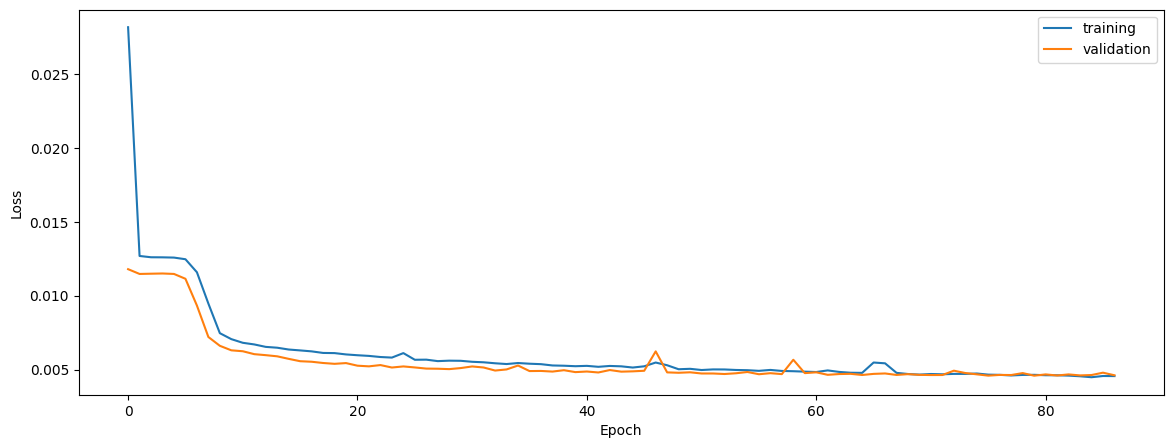

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.8022771899044282
0.7738954362955022
0.7822593633032957


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.8022771899044282
0.7738954362955022
0.7822593633032957


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.8046110063820296
0.7821694227060147
0.7739009511997288


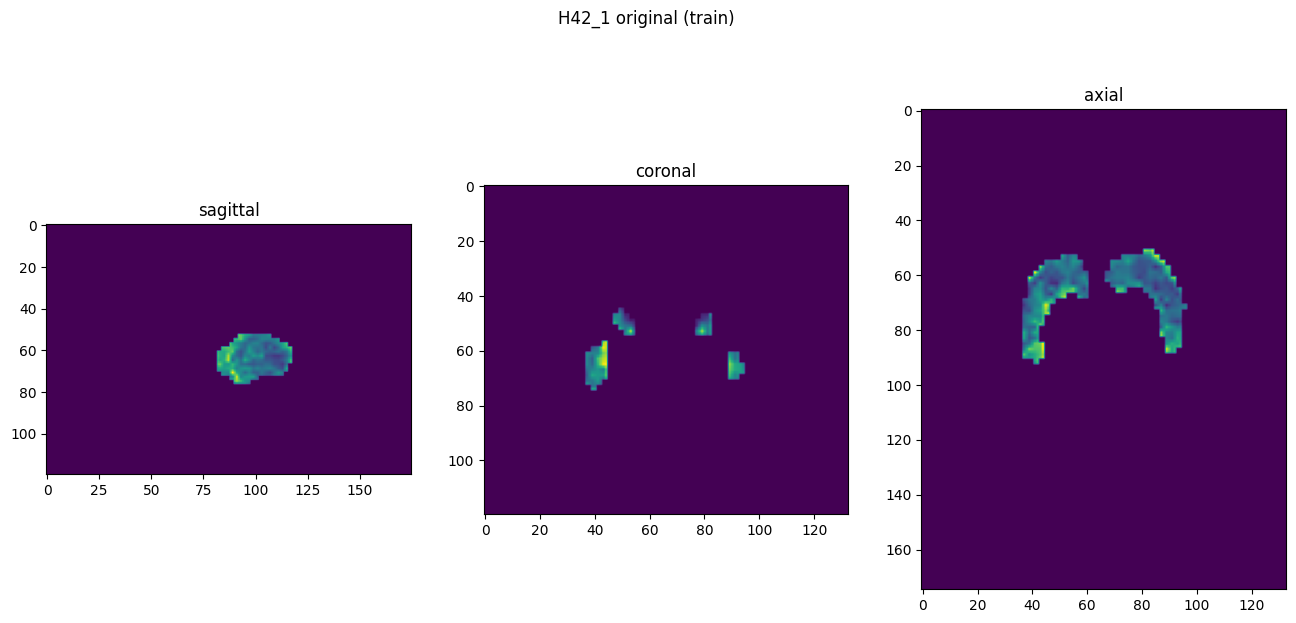

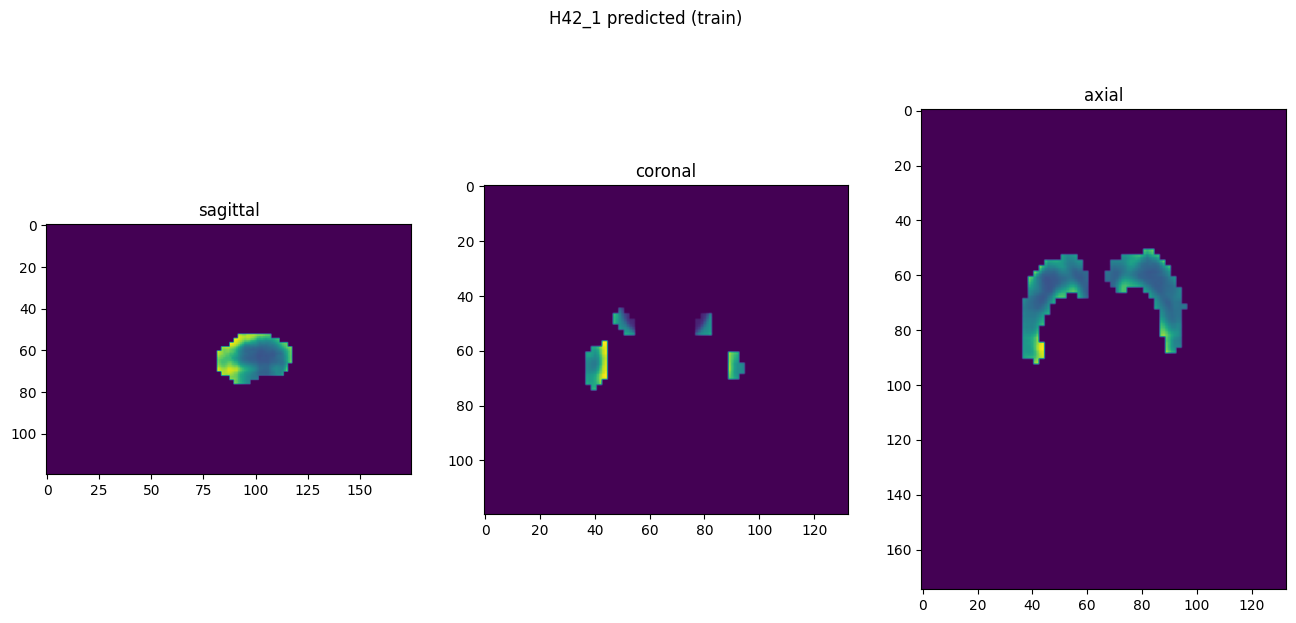

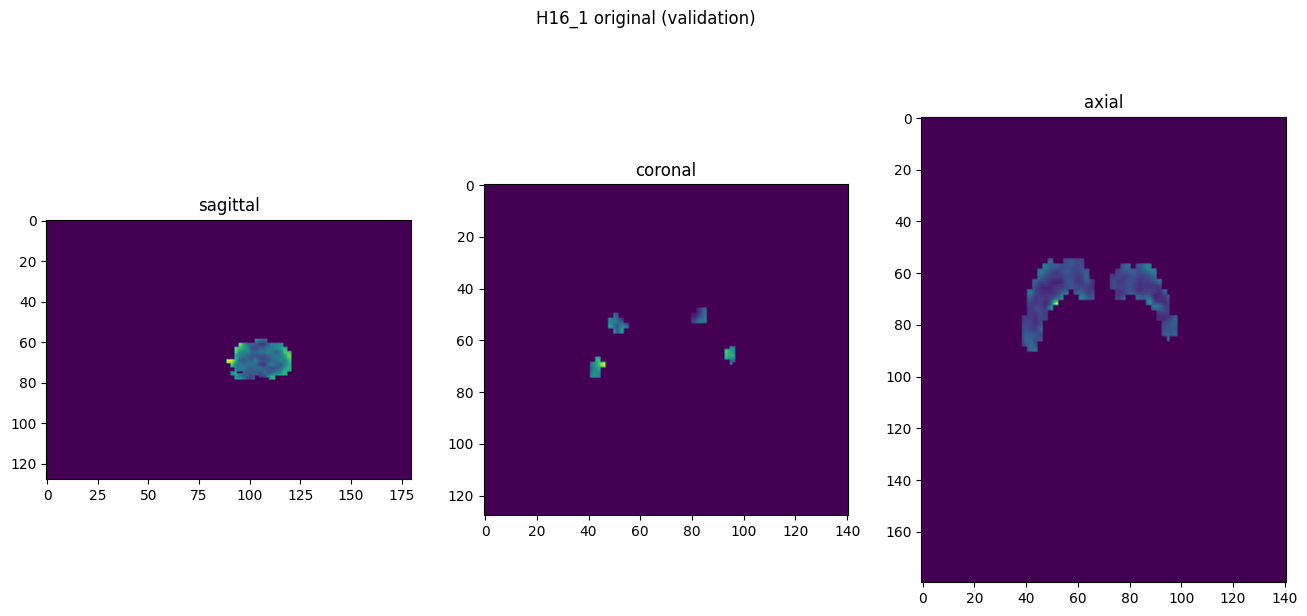

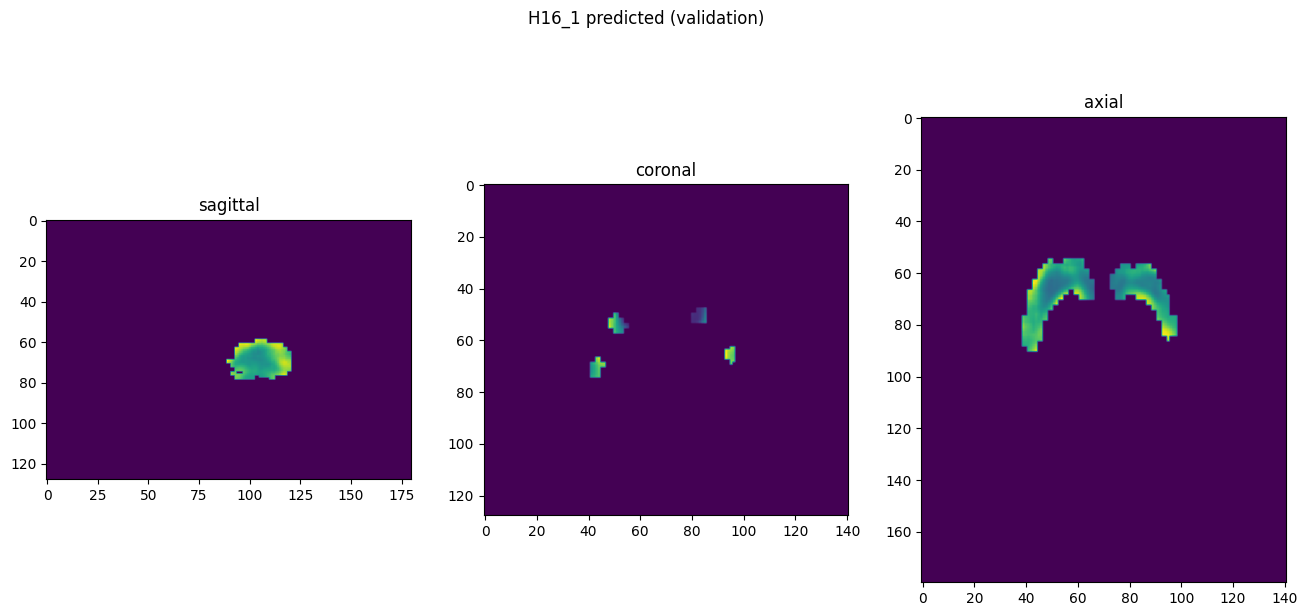

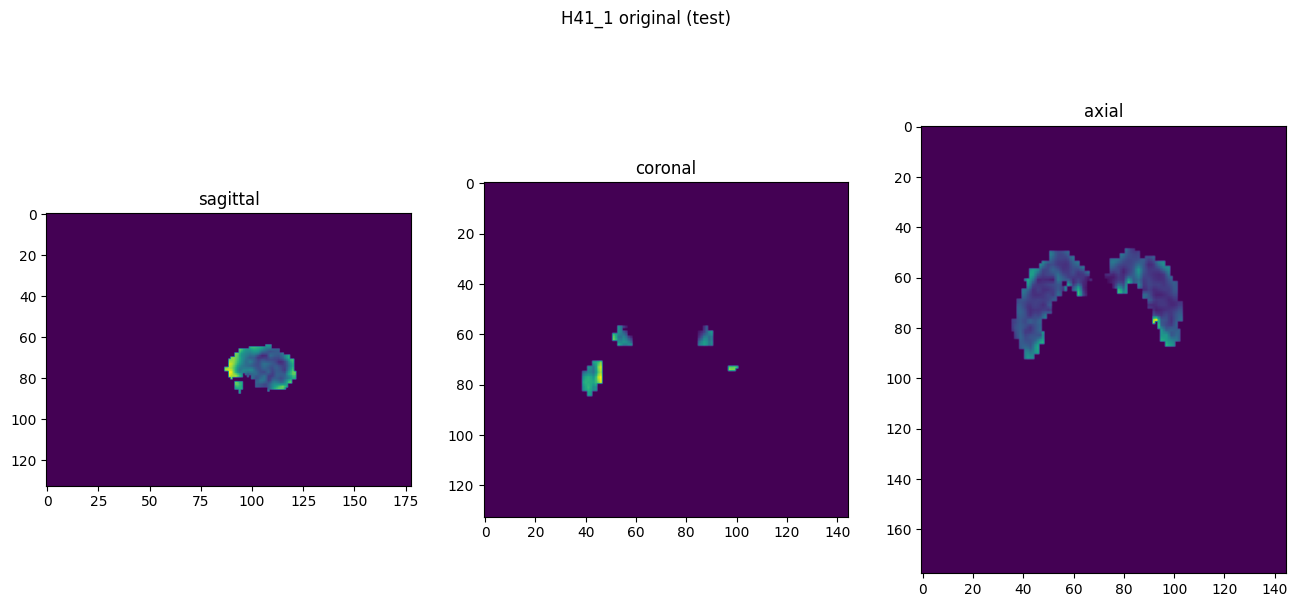

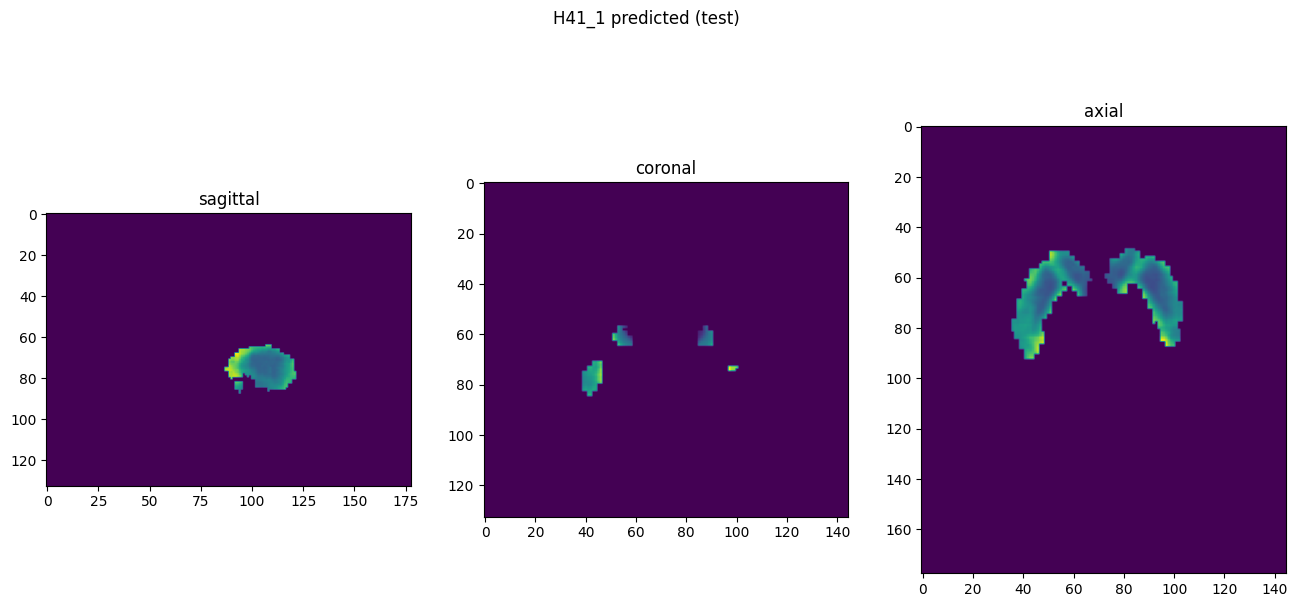

In [10]:
showResults(model, gen, threshold=None, background=False)